In [1]:
# ===============================
# Enhanced Imports for Mental Stress Detection
# ===============================
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')  # Better default styling
sns.set_palette("husl")

# NLP-specific imports
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# For frontend integration
import pickle
import joblib
from pathlib import Path
import logging
import json
from datetime import datetime

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Warnings
import warnings
warnings.filterwarnings('ignore')

# ===============================
# Setup logging for production readiness
# ===============================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('stress_detection.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# ===============================
# Create directories for model storage (frontend integration)
# ===============================
Path("models").mkdir(exist_ok=True)
Path("preprocessors").mkdir(exist_ok=True)
Path("reports").mkdir(exist_ok=True)

# ===============================
# Enhanced Data Loading Function
# ===============================
def load_and_validate_data(file_path, encoding='utf-8'):
    """
    Load stress detection dataset with comprehensive validation
    """
    try:
        # Try different encodings for robustness
        encodings = [encoding, 'utf-8', 'latin-1', 'cp1252']
        
        for enc in encodings:
            try:
                stress_df = pd.read_csv(file_path, 
                                      on_bad_lines='skip', 
                                      encoding=enc,
                                      low_memory=False)
                logger.info(f"Successfully loaded data with {enc} encoding")
                break
            except UnicodeDecodeError:
                continue
        
        # Basic data validation
        logger.info(f"Dataset shape: {stress_df.shape}")
        logger.info(f"Columns: {list(stress_df.columns)}")
        
        # Check for missing values
        missing_info = stress_df.isnull().sum()
        if missing_info.sum() > 0:
            logger.warning(f"Missing values found:\n{missing_info[missing_info > 0]}")
        
        # Check data types
        logger.info(f"Data types:\n{stress_df.dtypes}")
        
        return stress_df
        
    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        raise

# ===============================
# Load Data
# ===============================
logger.info("Loading stress detection dataset...")
stress_c = load_and_validate_data('stress.csv')

# Create working copy
stress = stress_c.copy()

# ===============================
# Initial Data Exploration
# ===============================
print("="*50)
print("MENTAL STRESS DETECTION - DATASET OVERVIEW")
print("="*50)

# Basic info
print(f"Dataset Shape: {stress.shape}")
print(f"Memory Usage: {stress.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
print("\nFirst 5 rows:")
print(stress.head())

# Column information
print(f"\nColumns: {list(stress.columns)}")
print(f"\nData Types:")
for col in stress.columns:
    print(f"  {col}: {stress[col].dtype}")

# ===============================
# Mental Health Specific Data Validation
# ===============================
def validate_stress_data(df):
    """
    Validate data specific to mental stress detection
    """
    validation_report = {
        'total_samples': len(df),
        'missing_values': df.isnull().sum().to_dict(),
        'duplicate_rows': df.duplicated().sum(),
        'text_columns': [],
        'label_column': None,
        'issues': []
    }
    
    # Identify text columns (likely to contain stress-related text)
    for col in df.columns:
        if df[col].dtype == 'object':
            # Check if it's likely text data
            avg_length = df[col].dropna().astype(str).str.len().mean()
            if avg_length > 10:  # Assuming text columns have longer strings
                validation_report['text_columns'].append(col)
            else:
                # Might be label column
                unique_vals = df[col].nunique()
                if unique_vals <= 10:  # Assuming labels have few unique values
                    validation_report['label_column'] = col
                    print(f"\nPossible label column '{col}' with values: {df[col].unique()}")
    
    # Check for very short or empty text entries
    for text_col in validation_report['text_columns']:
        short_texts = df[df[text_col].astype(str).str.len() < 5].shape[0]
        if short_texts > 0:
            validation_report['issues'].append(f"Column '{text_col}': {short_texts} very short texts")
    
    return validation_report

# Run validation
validation_info = validate_stress_data(stress)
print(f"\nValidation Report:")
print(f"- Total samples: {validation_info['total_samples']}")
print(f"- Text columns detected: {validation_info['text_columns']}")
print(f"- Possible label column: {validation_info['label_column']}")
print(f"- Duplicate rows: {validation_info['duplicate_rows']}")

if validation_info['issues']:
    print(f"- Issues found:")
    for issue in validation_info['issues']:
        print(f"  * {issue}")

# ===============================
# Save preprocessing info for frontend
# ===============================
preprocessing_config = {
    'dataset_info': {
        'shape': stress.shape,
        'columns': list(stress.columns),
        'text_columns': validation_info['text_columns'],
        'label_column': validation_info['label_column']
    },
    'timestamp': datetime.now().isoformat()
}

with open('preprocessors/dataset_config.json', 'w') as f:
    json.dump(preprocessing_config, f, indent=2)

logger.info("Dataset configuration saved for frontend integration")
print(f"\nDataset successfully loaded and validated!")
print("Ready for next preprocessing steps...")

2025-10-14 17:13:49,133 - INFO - Loading stress detection dataset...
2025-10-14 17:13:49,160 - INFO - Successfully loaded data with utf-8 encoding
2025-10-14 17:13:49,160 - INFO - Dataset shape: (2838, 116)
2025-10-14 17:13:49,160 - INFO - Columns: ['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_l

MENTAL STRESS DETECTION - DATASET OVERVIEW
Dataset Shape: (2838, 116)
Memory Usage: 4.50 MB

First 5 rows:
          subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text     id  label  \
0  He said he had not felt that way before, sugge...  33181      1   
1  Hey there r/assistance, Not sure if this is th...   2606      0   
2  My mom then hit me with the newspaper and it s...  38816      1   
3  until i met my new boyfriend, he is amazing, h...    239      1   
4  October is Domestic Violence Awareness Month a...   1421      1   

   confidence  social_timestamp  social_karma  syntax_ari  ...  \
0         0.8        1521614353             5    1.806818  ...   
1         1.0        1527009817             4    9.429737  ... 

MENTAL STRESS DETECTION - EXPLORATORY DATA ANALYSIS

1. DATASET INFORMATION:
------------------------------
Shape: (2838, 116)
Memory Usage: 4.76 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Columns: 116 entries, subreddit to sentiment
dtypes: float64(106), int64(6), object(4)
memory usage: 2.5+ MB

2. MISSING VALUES:
------------------------------
subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64

3. STATISTICAL SUMMARY:
------------------------------
       subreddit post_id sentence_range  \
count       2838    2838           2838   
unique        10    2343            173   
top         ptsd  9md6qz         (0, 5)   
freq         584       6         

2025-10-14 17:13:49,409 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-14 17:13:49,413 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


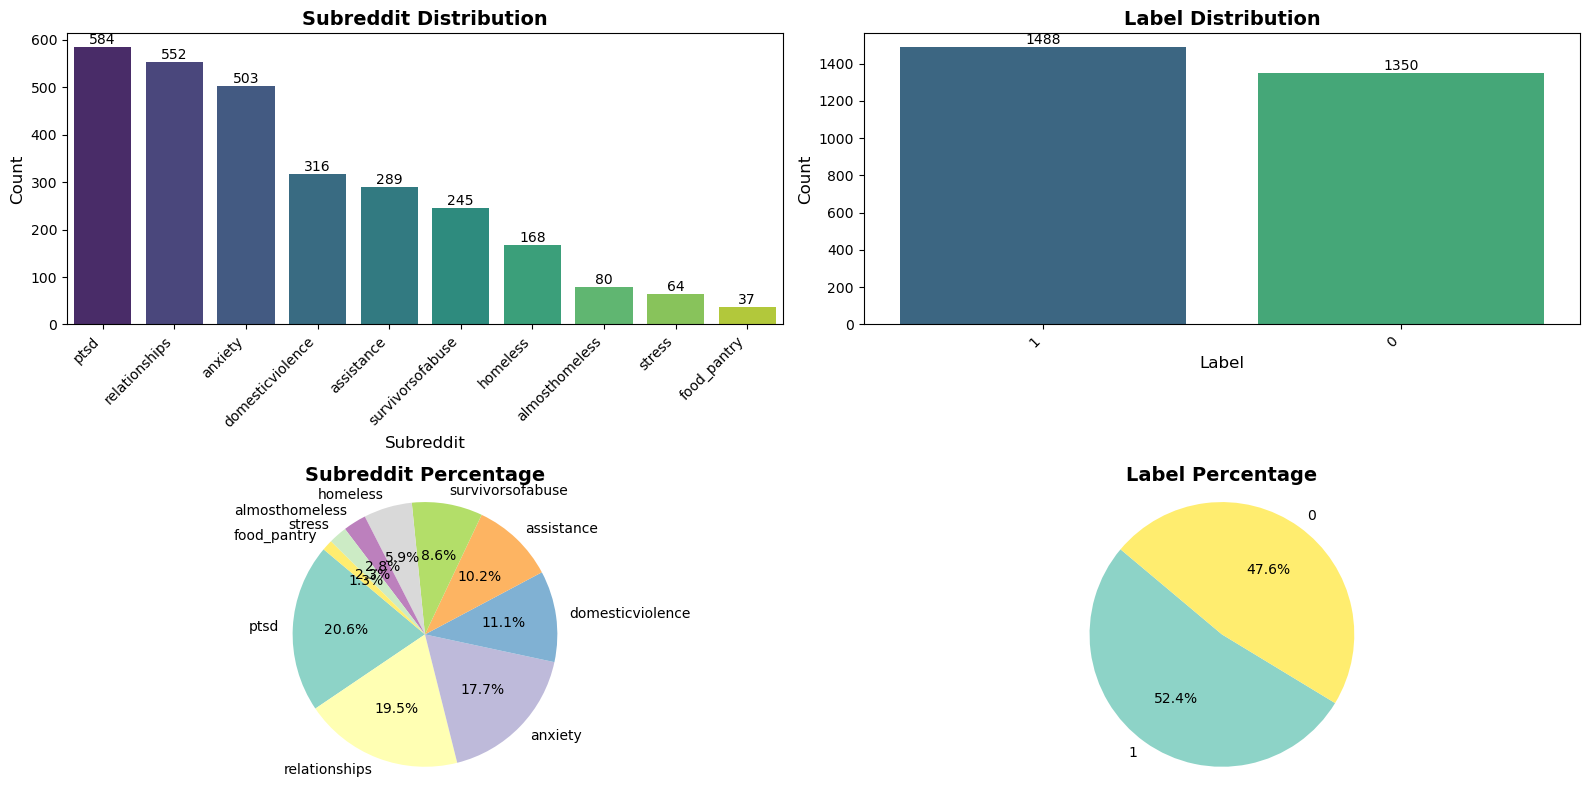

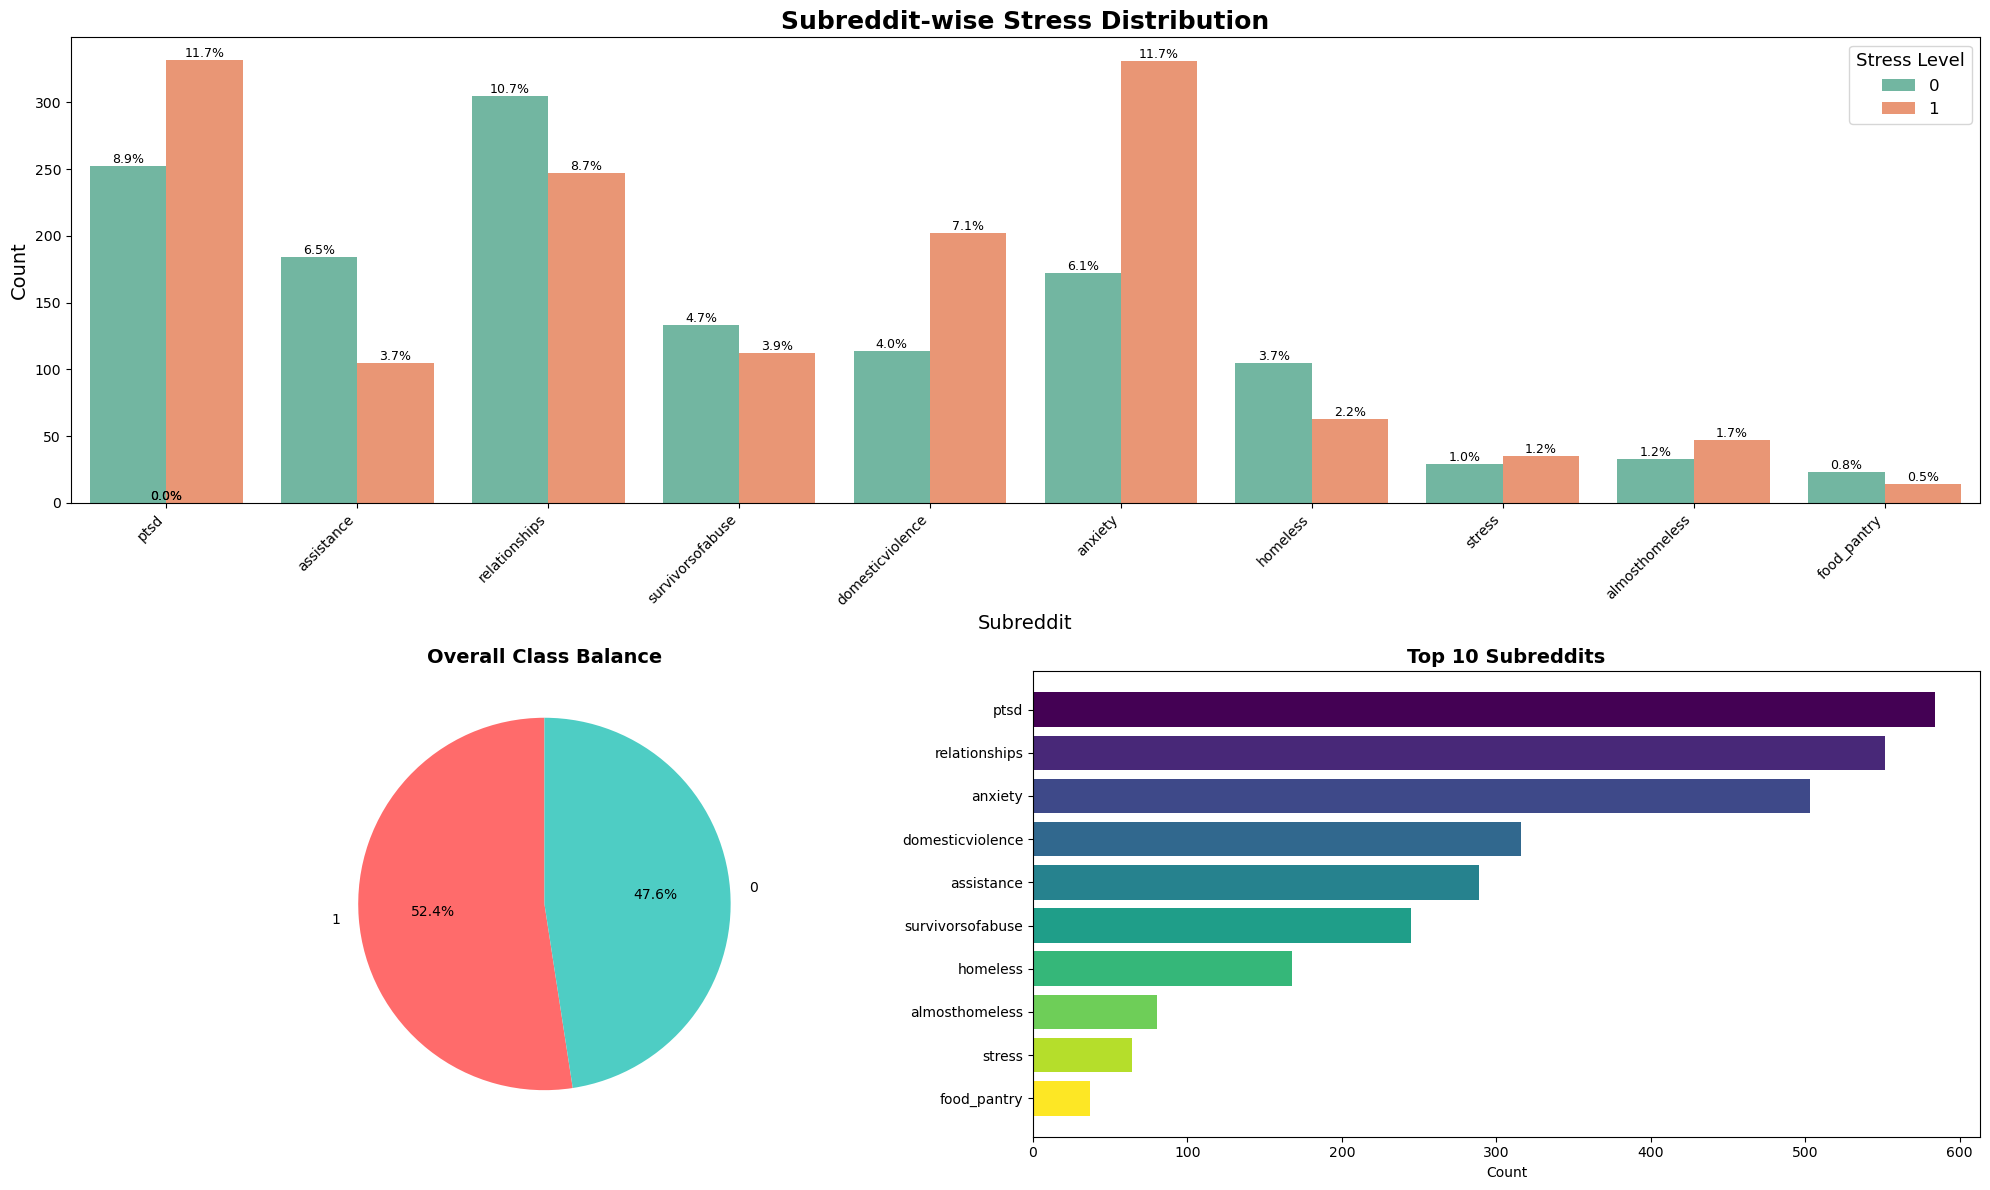


5. WORD CLOUD ANALYSIS:
------------------------------

Generating word clouds for column: post_id


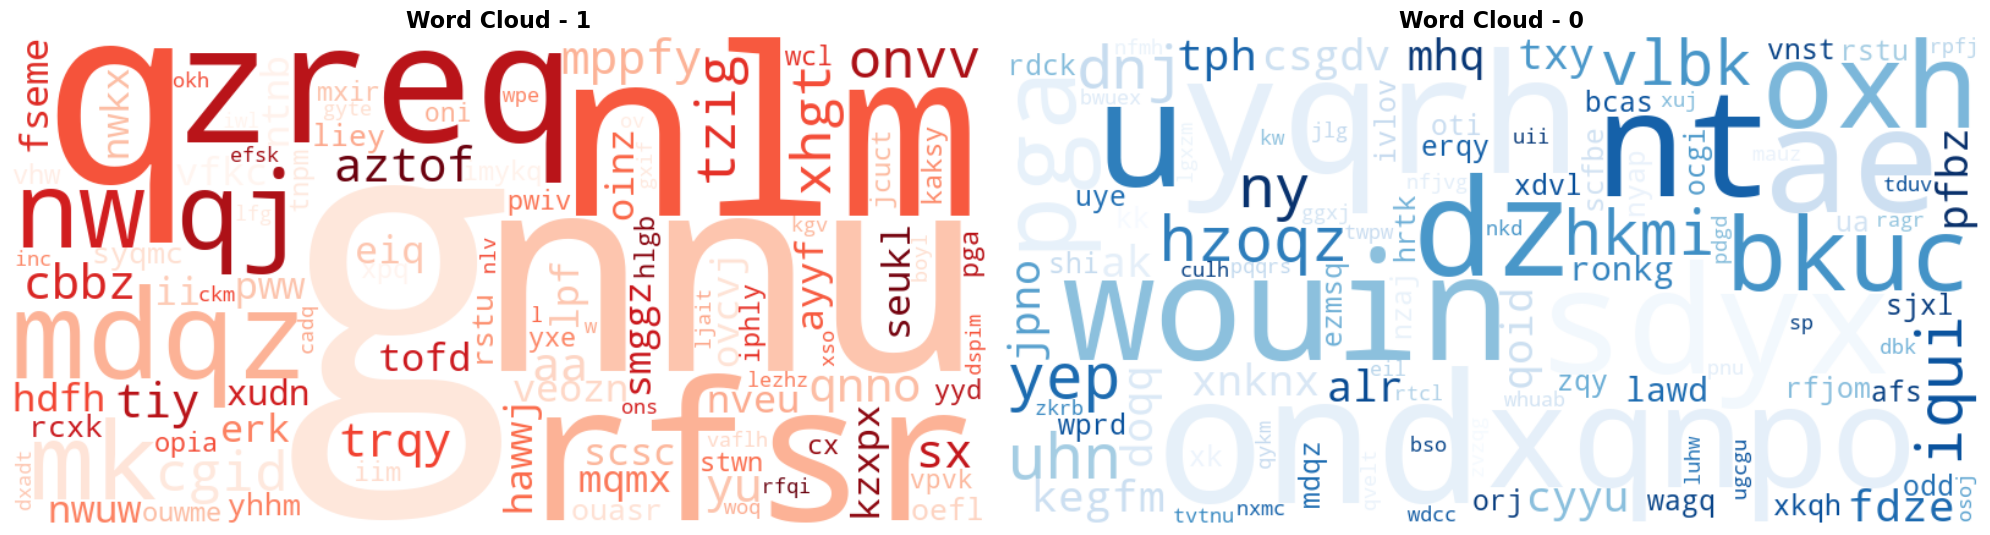

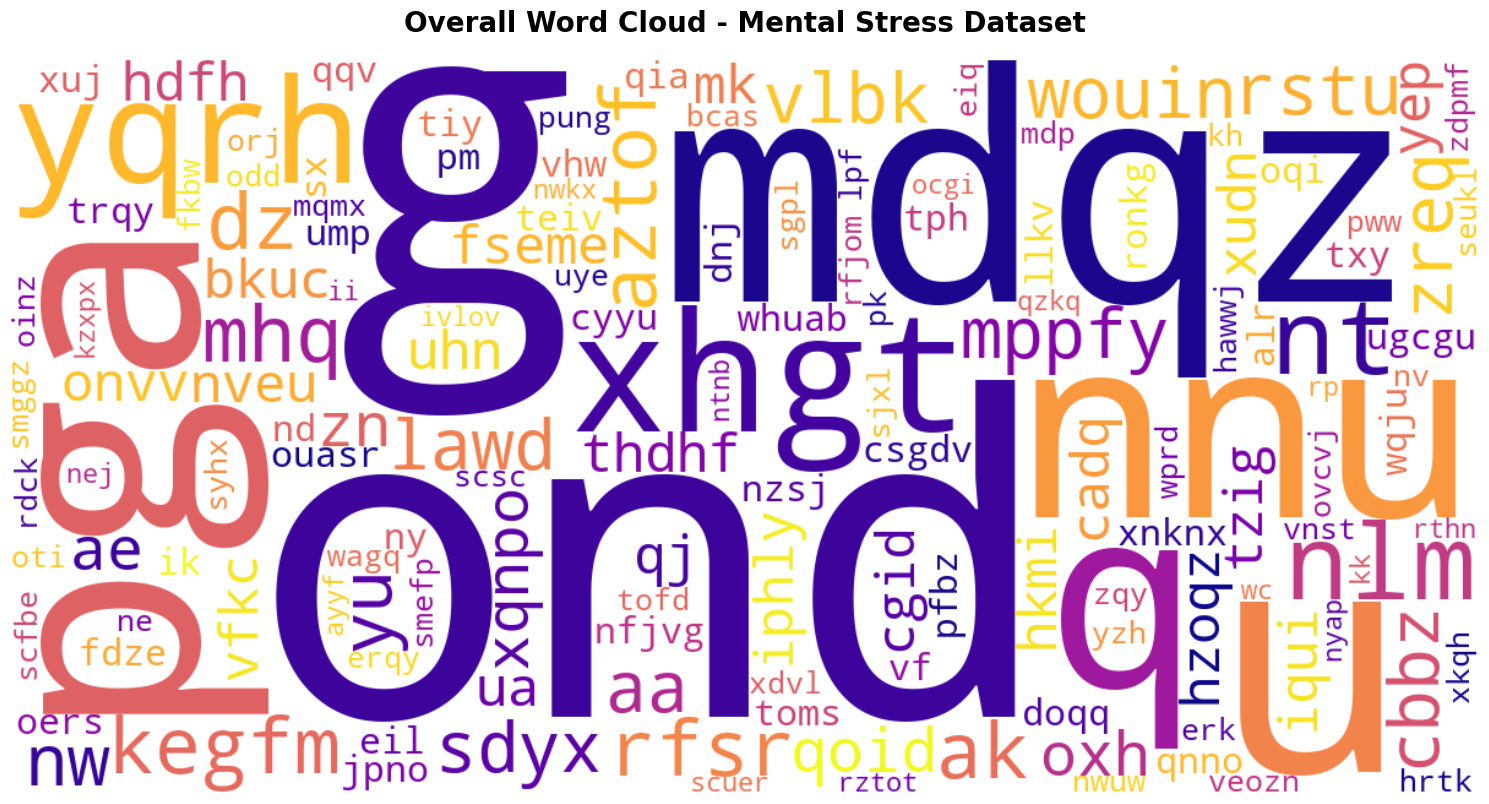


Generating word clouds for column: sentence_range


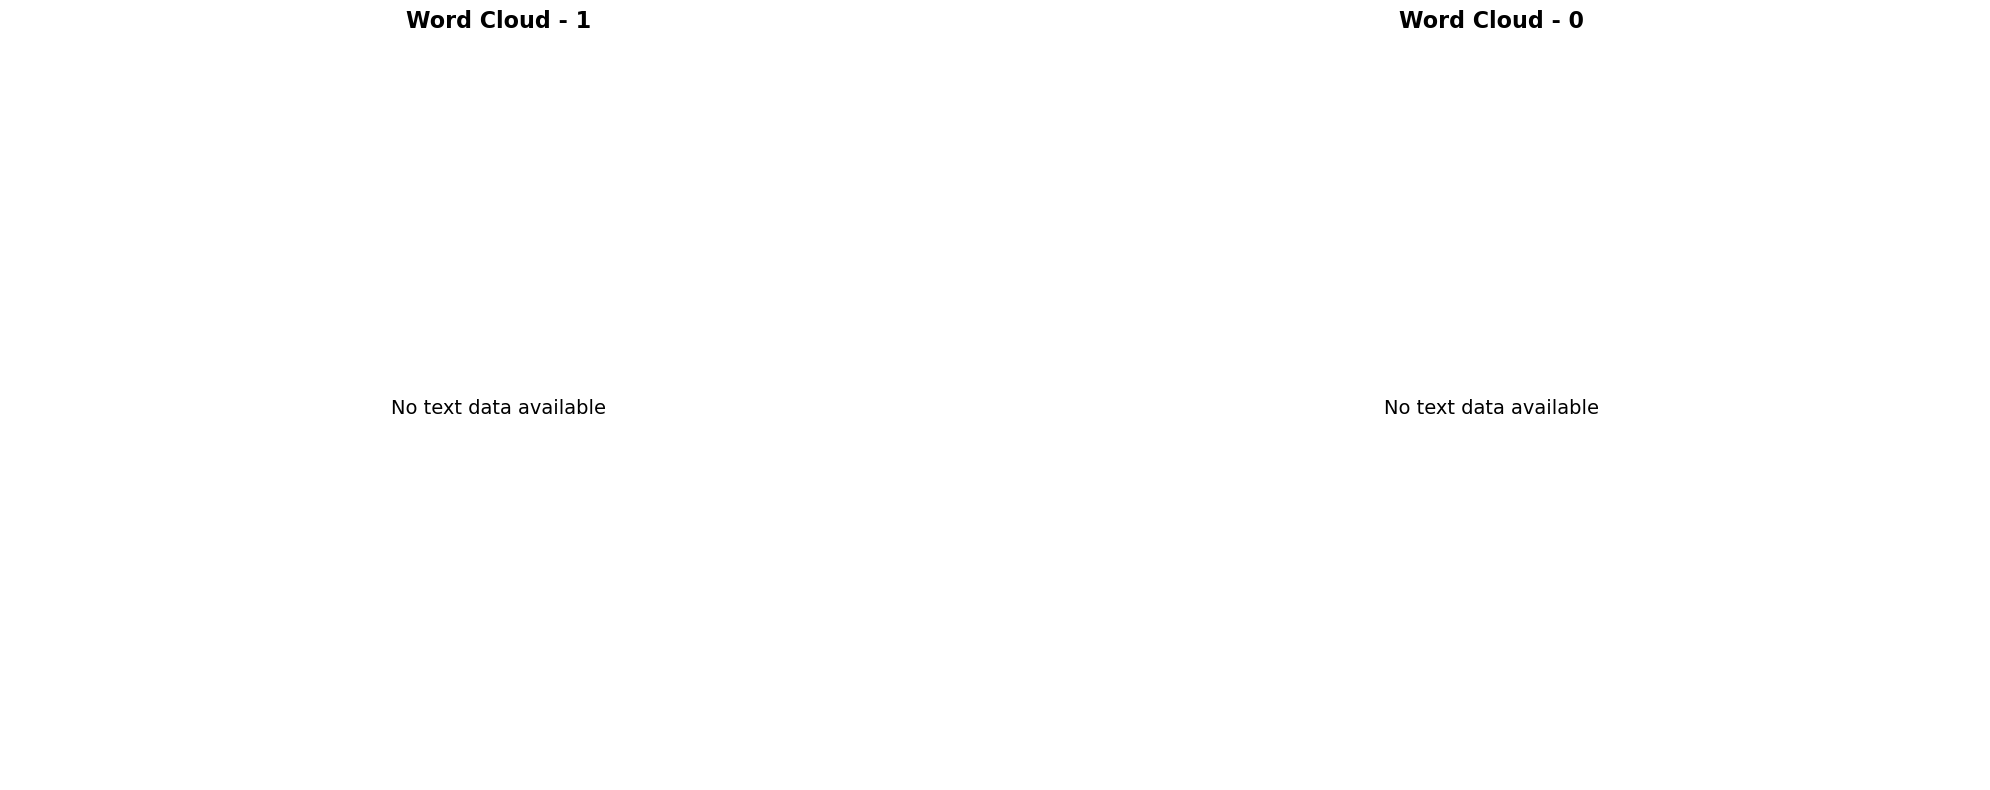


Generating word clouds for column: text


<Figure size 1500x1000 with 0 Axes>

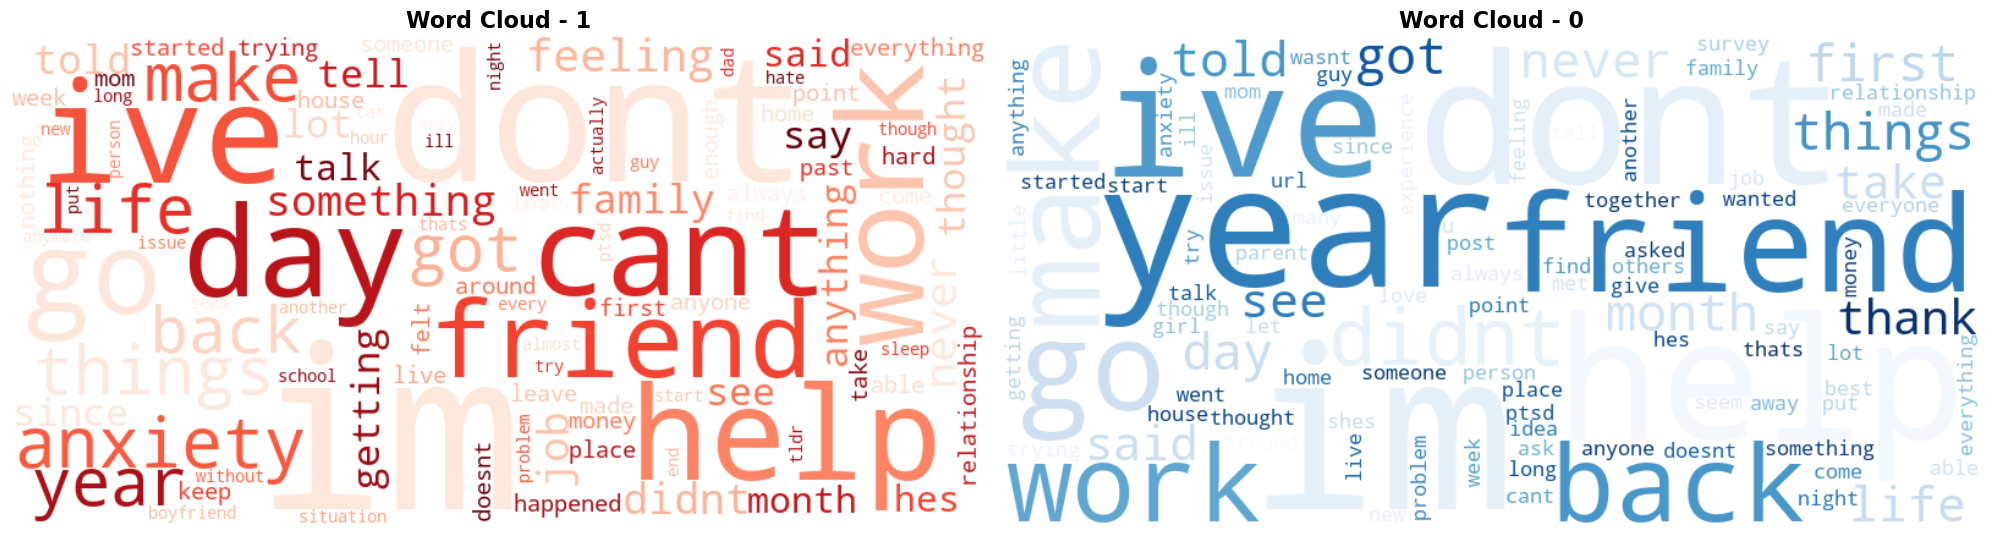

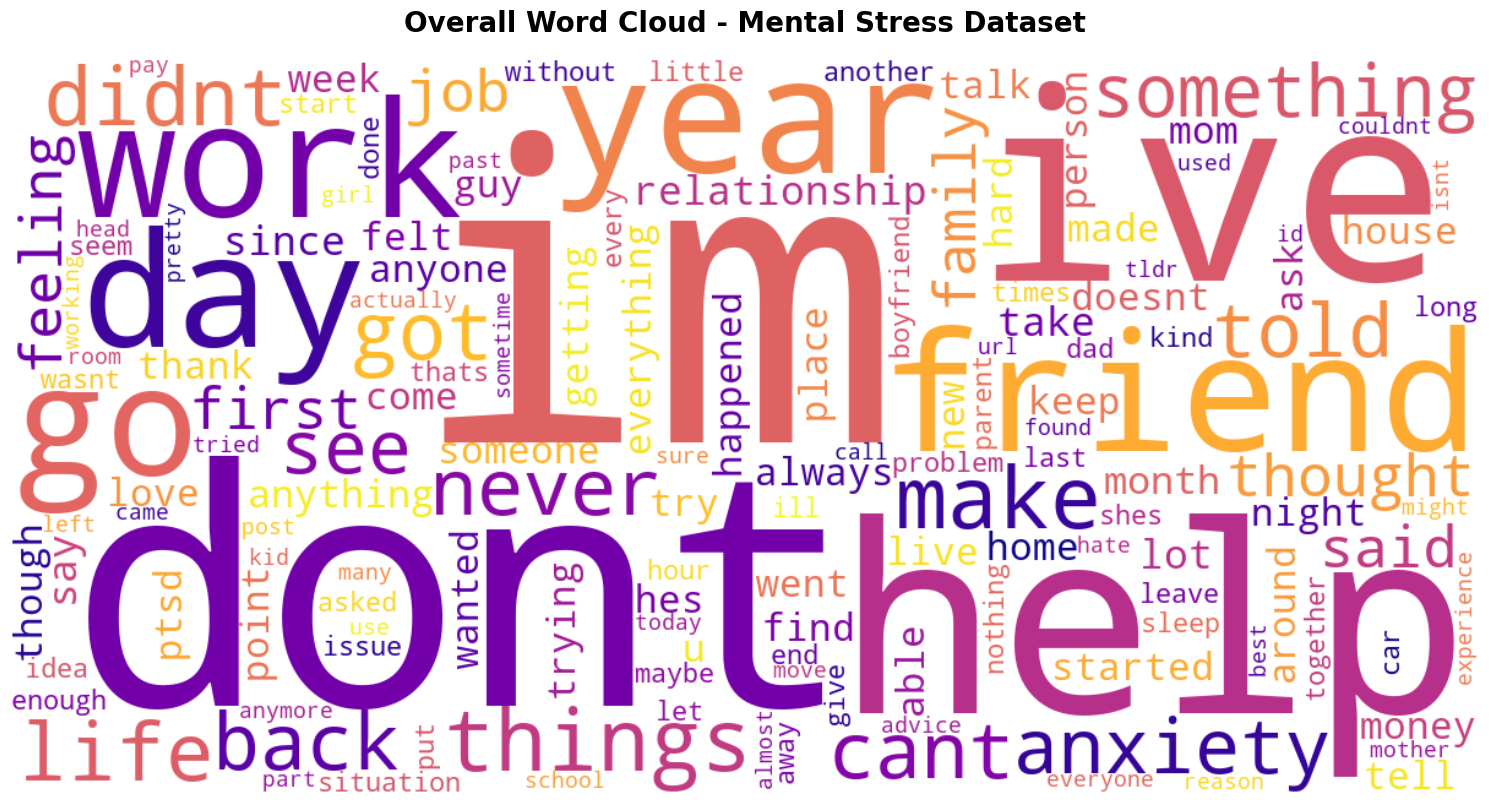


6. MENTAL HEALTH INSIGHTS:
------------------------------
Class Distribution:
  1: 0.524 (52.4%)
  0: 0.476 (47.6%)

Imbalance Ratio: 1.10

Subreddit Stress Patterns:
label                 0      1
subreddit                     
almosthomeless    0.412  0.588
anxiety           0.342  0.658
assistance        0.637  0.363
domesticviolence  0.361  0.639
food_pantry       0.622  0.378
homeless          0.625  0.375
ptsd              0.432  0.568
relationships     0.553  0.447
stress            0.453  0.547
survivorsofabuse  0.543  0.457

Analyzing stress level: 1
Top 3 High-Stress Subreddits:
  anxiety: 0.658 (65.8%)
  domesticviolence: 0.639 (63.9%)
  almosthomeless: 0.588 (58.8%)

Dataset Characteristics:
  Total samples: 2,838
  Unique subreddits: 10
  Subreddits with single posts: 0 (0.0%)

Top 5 Most Active Subreddits:
  ptsd: 584 posts (20.6%)
  relationships: 552 posts (19.5%)
  anxiety: 503 posts (17.7%)
  domesticviolence: 316 posts (11.1%)
  assistance: 289 posts (10.2%)

7. EDA

In [2]:
# ===============================
# Enhanced EDA for Mental Stress Detection
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data if not already present
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

# ===============================
# Basic Dataset Information
# ===============================
print("="*60)
print("MENTAL STRESS DETECTION - EXPLORATORY DATA ANALYSIS")
print("="*60)

# Dataset info
print("\n1. DATASET INFORMATION:")
print("-" * 30)
print(f"Shape: {stress.shape}")
print(f"Memory Usage: {stress.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display info
stress.info()

print("\n2. MISSING VALUES:")
print("-" * 30)
missing_data = stress.isnull().sum()
print(missing_data)

if missing_data.sum() > 0:
    print("\nMissing Value Percentages:")
    missing_percent = (stress.isnull().sum() / len(stress)) * 100
    print(missing_percent[missing_percent > 0])

print("\n3. STATISTICAL SUMMARY:")
print("-" * 30)
print(stress.describe(include='all'))

# ===============================
# Mental Health Specific Analysis
# ===============================
def analyze_text_columns(df):
    """Analyze text columns for mental health insights"""
    text_cols = df.select_dtypes(include=['object']).columns
    
    for col in text_cols:
        if col != 'label' and col != 'subreddit':  # Assuming these are categorical
            print(f"\n4. TEXT ANALYSIS - {col.upper()}:")
            print("-" * 30)
            
            # Text length analysis
            df[f'{col}_length'] = df[col].astype(str).str.len()
            df[f'{col}_word_count'] = df[col].astype(str).str.split().str.len()
            
            print(f"Average text length: {df[f'{col}_length'].mean():.2f} characters")
            print(f"Average word count: {df[f'{col}_word_count'].mean():.2f} words")
            print(f"Max text length: {df[f'{col}_length'].max()} characters")
            print(f"Min text length: {df[f'{col}_length'].min()} characters")
            
            # Short and long texts
            short_texts = len(df[df[f'{col}_length'] < 50])
            long_texts = len(df[df[f'{col}_length'] > 1000])
            print(f"Short texts (<50 chars): {short_texts} ({short_texts/len(df)*100:.1f}%)")
            print(f"Long texts (>1000 chars): {long_texts} ({long_texts/len(df)*100:.1f}%)")

analyze_text_columns(stress)

# ===============================
# Enhanced Visualizations
# ===============================
# Set professional style
plt.style.use('default')
sns.set_palette("husl")

# 1. Distribution Analysis
columns_to_plot = ['subreddit', 'label']
plt.figure(figsize=(16, 8))

for i, col in enumerate(columns_to_plot, start=1):
    plt.subplot(2, len(columns_to_plot), i)
    
    # Bar plot with enhanced styling
    ax = sns.countplot(data=stress, x=col, palette="viridis", 
                      order=stress[col].value_counts().index)
    plt.title(f"{col.capitalize()} Distribution", fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel("Count", fontsize=12)
    
    # Add value labels on bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width()/2., p.get_height()), 
                   ha='center', va='bottom', fontsize=10)
    
    # Pie chart subplot
    plt.subplot(2, len(columns_to_plot), i + len(columns_to_plot))
    counts = stress[col].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(counts)))
    plt.pie(counts, labels=counts.index, autopct="%.1f%%", 
           startangle=140, colors=colors, textprops={'fontsize': 10})
    plt.title(f"{col.capitalize()} Percentage", fontsize=14, fontweight='bold')
    plt.axis('equal')

plt.tight_layout()
plt.show()

# 2. Subreddit vs Stress Analysis
plt.figure(figsize=(20, 12))

# Main plot
plt.subplot(2, 2, (1, 2))
ax = sns.countplot(data=stress, x='subreddit', hue='label', palette='Set2')
plt.title('Subreddit-wise Stress Distribution', fontsize=18, fontweight='bold')
plt.xlabel('Subreddit', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stress Level', fontsize=12, title_fontsize=13)

# Add percentage labels
total = len(stress)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
               ha='center', va='bottom', fontsize=9)

# Class balance analysis
plt.subplot(2, 2, 3)
class_counts = stress['label'].value_counts()
colors = ['#FF6B6B', '#4ECDC4'] if len(class_counts) == 2 else plt.cm.Set2(np.arange(len(class_counts)))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Overall Class Balance', fontsize=14, fontweight='bold')

# Subreddit distribution
plt.subplot(2, 2, 4)
subreddit_counts = stress['subreddit'].value_counts().head(10)  # Top 10
plt.barh(range(len(subreddit_counts)), subreddit_counts.values, 
         color=plt.cm.viridis(np.linspace(0, 1, len(subreddit_counts))))
plt.yticks(range(len(subreddit_counts)), subreddit_counts.index)
plt.xlabel('Count')
plt.title('Top 10 Subreddits', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# ===============================
# Word Cloud Analysis
# ===============================
def create_mental_health_wordclouds(df, text_column):
    """Create word clouds specific to mental health analysis"""
    
    # Mental health specific stopwords
    mental_health_stopwords = set(stopwords.words('english')).union({
        'like', 'get', 'would', 'could', 'should', 'really', 'much', 'even',
        'also', 'still', 'think', 'feel', 'know', 'going', 'want', 'need',
        'one', 'way', 'people', 'time', 'good', 'bad', 'well', 'right', 'thing'
    })
    
    def clean_text_for_wordcloud(text):
        """Clean text specifically for mental health word clouds"""
        text = str(text).lower()
        # Remove URLs, mentions, hashtags
        text = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', text)
        # Remove punctuation and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
    
    # Create word clouds for each stress level
    unique_labels = df['label'].unique()
    n_labels = len(unique_labels)
    
    fig, axes = plt.subplots(1, n_labels, figsize=(20, 8))
    if n_labels == 1:
        axes = [axes]
    
    colors = ['Reds', 'Blues', 'Greens', 'Purples', 'Oranges']
    
    for i, label in enumerate(unique_labels):
        # Filter data for current label
        label_data = df[df['label'] == label]
        
        # Combine all text for this label
        all_text = ' '.join([clean_text_for_wordcloud(text) 
                            for text in label_data[text_column].dropna()])
        
        if all_text.strip():
            # Create word cloud
            wordcloud = WordCloud(
                width=800, height=400,
                background_color='white',
                stopwords=mental_health_stopwords,
                max_words=100,
                colormap=colors[i % len(colors)],
                relative_scaling=0.5,
                random_state=42
            ).generate(all_text)
            
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'Word Cloud - {label}', fontsize=16, fontweight='bold')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, 'No text data available', 
                        horizontalalignment='center', verticalalignment='center',
                        transform=axes[i].transAxes, fontsize=14)
            axes[i].set_title(f'Word Cloud - {label}', fontsize=16, fontweight='bold')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Overall word cloud
    plt.figure(figsize=(15, 10))
    all_text_combined = ' '.join([clean_text_for_wordcloud(text) 
                                 for text in df[text_column].dropna()])
    
    if all_text_combined.strip():
        wordcloud_all = WordCloud(
            width=1200, height=600,
            background_color='white',
            stopwords=mental_health_stopwords,
            max_words=150,
            colormap='plasma',
            relative_scaling=0.5,
            random_state=42
        ).generate(all_text_combined)
        
        plt.imshow(wordcloud_all, interpolation='bilinear')
        plt.title('Overall Word Cloud - Mental Stress Dataset', 
                 fontsize=20, fontweight='bold', pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Generate word clouds (assuming there's a text column)
text_columns = [col for col in stress.columns 
                if stress[col].dtype == 'object' and col not in ['label', 'subreddit']]

if text_columns:
    print(f"\n5. WORD CLOUD ANALYSIS:")
    print("-" * 30)
    for text_col in text_columns:
        print(f"\nGenerating word clouds for column: {text_col}")
        create_mental_health_wordclouds(stress, text_col)
else:
    print("\nNo text columns found for word cloud analysis")

# ===============================
# Advanced Mental Health Insights
# ===============================
def mental_health_insights(df):
    """Generate insights specific to mental health data"""
    
    print(f"\n6. MENTAL HEALTH INSIGHTS:")
    print("-" * 30)
    
    # Class imbalance analysis
    label_dist = df['label'].value_counts(normalize=True)
    print(f"Class Distribution:")
    for label, pct in label_dist.items():
        print(f"  {label}: {pct:.3f} ({pct*100:.1f}%)")
    
    # Imbalance ratio
    if len(label_dist) == 2:
        imbalance_ratio = label_dist.max() / label_dist.min()
        print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")
        
        if imbalance_ratio > 1.5:
            print("⚠️  Significant class imbalance detected!")
            print("   Consider: SMOTE, class weights, or stratified sampling")
    
    # Subreddit analysis
    if 'subreddit' in df.columns:
        subreddit_stress = pd.crosstab(df['subreddit'], df['label'], normalize='index')
        print(f"\nSubreddit Stress Patterns:")
        print(subreddit_stress.round(3))
        
        # Find most stressed subreddits (handle both numeric and text labels)
        if len(df['label'].unique()) == 2:
            # For numeric labels, assume higher value indicates stress
            unique_labels = sorted(df['label'].unique())
            
            # Check if labels are text-based
            if all(isinstance(label, str) for label in unique_labels):
                stress_labels = [label for label in unique_labels if any(word in label.lower() 
                               for word in ['stress', 'positive', '1', 'yes', 'true'])]
                stress_label = stress_labels[0] if stress_labels else unique_labels[-1]
            else:
                # For numeric labels, assume higher value = stress (1 = stressed, 0 = not stressed)
                stress_label = max(unique_labels)
            
            print(f"\nAnalyzing stress level: {stress_label}")
            high_stress_subreddits = subreddit_stress.nlargest(3, stress_label)
            print(f"Top 3 High-Stress Subreddits:")
            for subreddit, row in high_stress_subreddits.iterrows():
                print(f"  {subreddit}: {row[stress_label]:.3f} ({row[stress_label]*100:.1f}%)")
    
    # Additional insights for mental health
    print(f"\nDataset Characteristics:")
    print(f"  Total samples: {len(df):,}")
    print(f"  Unique subreddits: {df['subreddit'].nunique() if 'subreddit' in df.columns else 'N/A'}")
    
    # Check for potential data quality issues
    if 'subreddit' in df.columns:
        single_post_subreddits = df['subreddit'].value_counts()
        single_posts = (single_post_subreddits == 1).sum()
        print(f"  Subreddits with single posts: {single_posts} ({single_posts/len(single_post_subreddits)*100:.1f}%)")
        
        # Most active subreddits
        top_subreddits = df['subreddit'].value_counts().head(5)
        print(f"\nTop 5 Most Active Subreddits:")
        for subreddit, count in top_subreddits.items():
            print(f"  {subreddit}: {count} posts ({count/len(df)*100:.1f}%)")

mental_health_insights(stress)

# ===============================
# Save EDA Results for Frontend
# ===============================
eda_results = {
    'dataset_shape': stress.shape,
    'class_distribution': stress['label'].value_counts().to_dict(),
    'missing_values': stress.isnull().sum().to_dict(),
    'subreddit_distribution': stress['subreddit'].value_counts().head(10).to_dict() if 'subreddit' in stress.columns else {},
    'text_stats': {}
}

# Add text statistics
for col in stress.columns:
    if stress[col].dtype == 'object' and col not in ['label', 'subreddit']:
        eda_results['text_stats'][col] = {
            'avg_length': float(stress[col].astype(str).str.len().mean()),
            'avg_word_count': float(stress[col].astype(str).str.split().str.len().mean()),
            'max_length': int(stress[col].astype(str).str.len().max()),
            'min_length': int(stress[col].astype(str).str.len().min())
        }

# Save for frontend
import json
with open('reports/eda_results.json', 'w') as f:
    json.dump(eda_results, f, indent=2)

print(f"\n7. EDA COMPLETE!")
print("-" * 30)
print("✅ Visualizations generated")
print("✅ Word clouds created")  
print("✅ Mental health insights extracted")
print("✅ Results saved for frontend integration")
print("\nReady for text preprocessing and feature engineering!")

In [3]:
# ===============================
# Enhanced NLP Preprocessing for Mental Stress Detection
# ===============================
import re
import string
import time
from typing import List, Optional
import pandas as pd
import numpy as np

# NLP Libraries
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as SPACY_STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Visualization
from wordcloud import WordCloud, STOPWORDS as WC_STOPWORDS
from collections import Counter
import matplotlib.pyplot as plt

# Download NLTK resources
required_nltk_downloads = ["stopwords", "wordnet", "punkt", "omw-1.4", "vader_lexicon"]
for resource in required_nltk_downloads:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
    except LookupError:
        print(f"Downloading {resource}...")
        nltk.download(resource, quiet=True)

# Initialize spaCy model (optimized for speed)
try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tok2vec", "tagger", "attribute_ruler"])
except OSError:
    print("⚠️  spaCy model 'en_core_web_sm' not found. Using NLTK lemmatizer as fallback.")
    nlp = None

# ===============================
# Mental Health Specific Configuration
# ===============================
# Enhanced stopwords for mental health context
MENTAL_HEALTH_STOPWORDS = set(stopwords.words("english")).union({
    # Common social media words
    'like', 'get', 'would', 'could', 'should', 'really', 'much', 'even',
    'also', 'still', 'think', 'feel', 'know', 'going', 'want', 'need',
    'one', 'way', 'people', 'time', 'good', 'bad', 'well', 'right', 'thing',
    # Reddit-specific
    'reddit', 'post', 'comment', 'subreddit', 'thread', 'op', 'edit', 'update',
    # Mental health context fillers
    'really', 'pretty', 'quite', 'very', 'super', 'totally', 'completely',
    'absolutely', 'definitely', 'probably', 'maybe', 'perhaps', 'might'
})

# Mental health keywords to preserve (don't remove these)
PRESERVE_KEYWORDS = {
    'stress', 'stressed', 'anxiety', 'anxious', 'depression', 'depressed',
    'panic', 'worry', 'fear', 'overwhelmed', 'tired', 'exhausted',
    'sad', 'happy', 'angry', 'frustrated', 'hopeless', 'helpless',
    'therapy', 'counseling', 'medication', 'sleep', 'insomnia',
    'work', 'job', 'family', 'relationship', 'health', 'money',
    'support', 'help', 'better', 'worse', 'difficult', 'hard', 'easy'
}

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# ===============================
# Enhanced Preprocessing Functions
# ===============================
def clean_social_media_text(text: str) -> str:
    """Clean social media specific elements"""
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove Reddit-specific patterns
    text = re.sub(r'/u/[A-Za-z0-9_-]+', '', text)  # usernames
    text = re.sub(r'/r/[A-Za-z0-9_-]+', '', text)  # subreddits
    text = re.sub(r'\[deleted\]|\[removed\]', '', text)  # deleted content
    
    # Remove social media mentions and hashtags
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    
    # Remove excessive punctuation but preserve single instances
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[.]{2,}', '.', text)
    
    # Remove excessive capitalization (keep emphasis but reduce noise)
    text = re.sub(r'([A-Z]){3,}', lambda m: m.group(1)[:2], text)
    
    return text

def advanced_preprocess(text: str, 
                       remove_digits: bool = True,
                       min_word_length: int = 2,
                       preserve_emphasis: bool = True) -> str:
    """Enhanced preprocessing with mental health considerations"""
    
    if pd.isna(text) or text == '':
        return ''
    
    # Clean social media elements
    text = clean_social_media_text(text)
    
    # Handle contractions (important for emotional context)
    contractions = {
        "won't": "will not", "can't": "cannot", "n't": " not",
        "'re": " are", "'ve": " have", "'ll": " will", "'d": " would",
        "'m": " am", "it's": "it is", "that's": "that is"
    }
    
    for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text, flags=re.IGNORECASE)
    
    # Convert to lowercase but preserve some emotional emphasis
    if preserve_emphasis:
        # Mark words that are all caps (potential emotional emphasis)
        caps_words = re.findall(r'\b[A-Z]{2,}\b', text)
        caps_map = {word: f"EMPH_{word.lower()}" for word in caps_words}
        for caps_word, emph_word in caps_map.items():
            text = text.replace(caps_word, emph_word)
    
    text = text.lower()
    
    # Remove/replace special characters strategically
    text = re.sub(r'[^\w\s!?.]', ' ', text)  # Keep some punctuation for emotional context
    
    # Remove digits if specified
    if remove_digits:
        text = re.sub(r'\b\d+\b', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize and filter
    words = text.split()
    
    # Filter words
    filtered_words = []
    for word in words:
        # Skip if too short
        if len(word) < min_word_length:
            continue
        
        # Preserve mental health keywords even if they're in stopwords
        if word in PRESERVE_KEYWORDS or word.startswith('emph_'):
            filtered_words.append(word)
        # Remove stopwords
        elif word not in MENTAL_HEALTH_STOPWORDS:
            filtered_words.append(word)
    
    return " ".join(filtered_words)

def smart_lemmatize(text: str) -> str:
    """Intelligent lemmatization with fallback"""
    if pd.isna(text) or text == '':
        return ''
    
    words = text.split()
    lemmatized_words = []
    
    if nlp is not None:
        # Use spaCy for better lemmatization
        try:
            doc = nlp(text)
            lemmatized_words = [
                token.lemma_ if token.lemma_ != '-PRON-' else token.text.lower()
                for token in doc
                if not token.is_space
            ]
        except:
            # Fallback to NLTK
            lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    else:
        # Use NLTK lemmatizer
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Filter out empty strings and join
    return " ".join([word for word in lemmatized_words if word.strip()])

def comprehensive_text_cleaning(text: str, 
                              remove_digits: bool = True,
                              preserve_emphasis: bool = True,
                              min_word_length: int = 2) -> str:
    """Complete text cleaning pipeline optimized for mental health analysis"""
    
    if pd.isna(text) or text == '':
        return ''
    
    # Step 1: Advanced preprocessing
    cleaned = advanced_preprocess(
        text, 
        remove_digits=remove_digits,
        min_word_length=min_word_length,
        preserve_emphasis=preserve_emphasis
    )
    
    # Step 2: Lemmatization
    lemmatized = smart_lemmatize(cleaned)
    
    # Step 3: Final cleanup
    # Remove extra spaces and ensure non-empty result
    final_text = re.sub(r'\s+', ' ', lemmatized).strip()
    
    return final_text if final_text else 'empty_text'

# ===============================
# Batch Processing with Progress
# ===============================
def process_texts_batch(texts: pd.Series, batch_size: int = 1000) -> pd.Series:
    """Process texts in batches with progress tracking"""
    
    print(f"Processing {len(texts)} texts in batches of {batch_size}...")
    
    processed_texts = []
    total_batches = len(texts) // batch_size + (1 if len(texts) % batch_size else 0)
    
    start_time = time.time()
    
    for i in range(0, len(texts), batch_size):
        batch = texts.iloc[i:i+batch_size]
        batch_processed = batch.apply(comprehensive_text_cleaning)
        processed_texts.extend(batch_processed.tolist())
        
        # Progress update
        batch_num = i // batch_size + 1
        elapsed_time = time.time() - start_time
        avg_time_per_batch = elapsed_time / batch_num
        estimated_remaining = (total_batches - batch_num) * avg_time_per_batch
        
        print(f"Batch {batch_num}/{total_batches} - "
              f"Elapsed: {elapsed_time:.1f}s - "
              f"ETA: {estimated_remaining:.1f}s")
    
    total_time = time.time() - start_time
    print(f"✅ Processing complete! Total time: {total_time:.1f}s")
    
    return pd.Series(processed_texts, index=texts.index)

# ===============================
# Apply Enhanced Preprocessing
# ===============================
print("="*60)
print("ENHANCED TEXT PREPROCESSING FOR MENTAL STRESS DETECTION")
print("="*60)

# Identify text column (assuming it's called 'text')
text_columns = [col for col in stress.columns if stress[col].dtype == 'object' 
                and col not in ['label', 'subreddit']]

if not text_columns:
    print("⚠️  No text columns found! Please specify the correct column name.")
    print(f"Available columns: {list(stress.columns)}")
else:
    text_col = text_columns[0]  # Use first text column found
    print(f"Processing text column: '{text_col}'")
    
    # Show sample of original text
    print(f"\nSample original texts:")
    for i, text in enumerate(stress[text_col].dropna().head(3), 1):
        print(f"{i}. {text[:100]}...")
    
    # Process texts
    stress['clean_text'] = process_texts_batch(stress[text_col])
    
    # Show sample of cleaned text
    print(f"\nSample cleaned texts:")
    for i, (orig, clean) in enumerate(zip(stress[text_col].dropna().head(3), 
                                         stress['clean_text'].dropna().head(3)), 1):
        print(f"{i}. Original: {orig[:80]}...")
        print(f"   Cleaned:  {clean[:80]}...")
        print()
    
    # Text cleaning statistics
    print("TEXT CLEANING STATISTICS:")
    print("-" * 30)
    
    original_lengths = stress[text_col].astype(str).str.len()
    cleaned_lengths = stress['clean_text'].astype(str).str.len()
    
    print(f"Average original length: {original_lengths.mean():.1f} chars")
    print(f"Average cleaned length:  {cleaned_lengths.mean():.1f} chars")
    print(f"Length reduction:        {(1 - cleaned_lengths.mean()/original_lengths.mean())*100:.1f}%")
    
    # Word count statistics
    original_words = stress[text_col].astype(str).str.split().str.len()
    cleaned_words = stress['clean_text'].astype(str).str.split().str.len()
    
    print(f"Average original words:   {original_words.mean():.1f}")
    print(f"Average cleaned words:    {cleaned_words.mean():.1f}")
    print(f"Word reduction:          {(1 - cleaned_words.mean()/original_words.mean())*100:.1f}%")
    
    # Check for empty texts after cleaning
    empty_texts = (stress['clean_text'] == 'empty_text').sum()
    if empty_texts > 0:
        print(f"⚠️  {empty_texts} texts became empty after cleaning")
    
    print(f"\n✅ Text preprocessing complete!")
    print(f"New column 'clean_text' added to dataset")

# ===============================
# Save Preprocessing Configuration
# ===============================
preprocessing_config = {
    'stopwords_count': len(MENTAL_HEALTH_STOPWORDS),
    'preserved_keywords': list(PRESERVE_KEYWORDS),
    'processing_settings': {
        'remove_digits': True,
        'preserve_emphasis': True,
        'min_word_length': 2
    },
    'lemmatization_tool': 'spacy' if nlp is not None else 'nltk',
    'text_column_processed': text_columns[0] if text_columns else None
}

import json
with open('preprocessors/text_preprocessing_config.json', 'w') as f:
    json.dump(preprocessing_config, f, indent=2)

print("📁 Preprocessing configuration saved for frontend integration")

# Display final dataset info
print(f"\nFinal dataset shape: {stress.shape}")
stress.head()

⚠️  spaCy model 'en_core_web_sm' not found. Using NLTK lemmatizer as fallback.
ENHANCED TEXT PREPROCESSING FOR MENTAL STRESS DETECTION
Processing text column: 'post_id'

Sample original texts:
1. 8601tu...
2. 8lbrx9...
3. 9ch1zh...
Processing 2838 texts in batches of 1000...
Batch 1/3 - Elapsed: 1.4s - ETA: 2.7s
Batch 2/3 - Elapsed: 1.4s - ETA: 0.7s
Batch 3/3 - Elapsed: 1.4s - ETA: 0.0s
✅ Processing complete! Total time: 1.4s

Sample cleaned texts:
1. Original: 8601tu...
   Cleaned:  8601tu...

2. Original: 8lbrx9...
   Cleaned:  8lbrx9...

3. Original: 9ch1zh...
   Cleaned:  9ch1zh...

TEXT CLEANING STATISTICS:
------------------------------
Average original length: 6.0 chars
Average cleaned length:  6.0 chars
Length reduction:        -0.1%
Average original words:   1.0
Average cleaned words:    1.0
Word reduction:          0.0%
⚠️  5 texts became empty after cleaning

✅ Text preprocessing complete!
New column 'clean_text' added to dataset
📁 Preprocessing configuration saved for front

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,social_num_comments,syntax_fk_grade,sentiment,post_id_length,post_id_word_count,sentence_range_length,sentence_range_word_count,text_length,text_word_count,clean_text
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1,3.253573,-0.002742,6,1,8,2,571,113,8601tu
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,2,8.828316,0.292857,6,1,6,2,588,108,8lbrx9
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,0,7.841667,0.011894,6,1,8,2,847,166,9ch1zh
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,5,4.104027,0.141671,6,1,7,2,1277,273,7rorpp
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1,7.910952,-0.204167,6,1,6,2,533,89,9p2gbc


In [4]:
#cell1
import nltk
import ssl

# Fix SSL issues if any
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required NLTK data - using the correct resource names
nltk_resources = [
    'punkt_tab',  # Updated punkt tokenizer
    'stopwords',
    'wordnet',
    'averaged_perceptron_tagger',
    'maxent_ne_chunker',
    'words',
    'vader_lexicon'
]

print("Downloading NLTK resources...")
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}' if 'punkt' in resource else 
                      f'corpora/{resource}' if resource in ['stopwords', 'wordnet', 'words'] else
                      f'sentiment/{resource}' if 'vader' in resource else
                      f'taggers/{resource}' if 'tagger' in resource else
                      f'chunkers/{resource}')
        print(f"✓ {resource} already available")
    except LookupError:
        print(f"Downloading {resource}...")
        nltk.download(resource, quiet=True)
        print(f"✓ {resource} downloaded")

print("All NLTK resources ready!")

✓ punkt_tab already available
✓ stopwords already available
✓ wordnet downloaded
✓ averaged_perceptron_tagger already available
✓ maxent_ne_chunker already available
✓ words already available
✓ vader_lexicon downloaded
All NLTK resources ready!


In [5]:

#cell2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
import joblib
import json
from datetime import datetime
import re
from collections import Counter
warnings.filterwarnings('ignore')

# Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag

# Vectorization & Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, 
    cross_val_predict, GridSearchCV, RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score,
    matthews_corrcoef, balanced_accuracy_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, 
    ExtraTreesClassifier, GradientBoostingClassifier,
    StackingClassifier, VotingClassifier, BaggingClassifier,
    HistGradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Advanced Models
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not available")
    XGBOOST_AVAILABLE = False

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("LightGBM not available")
    LIGHTGBM_AVAILABLE = False

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    print("CatBoost not available")
    CATBOOST_AVAILABLE = False

# Text analysis
try:
    from textstat import flesch_reading_ease, flesch_kincaid_grade
    TEXTSTAT_AVAILABLE = True
except ImportError:
    print("TextStat not available - installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "textstat"])
    from textstat import flesch_reading_ease, flesch_kincaid_grade
    TEXTSTAT_AVAILABLE = True

try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    VADER_AVAILABLE = True
except ImportError:
    print("VaderSentiment not available - installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "vaderSentiment"])
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    VADER_AVAILABLE = True

print("All imports completed successfully!")

XGBoost not available
LightGBM not available
CatBoost not available
All imports completed successfully!


In [6]:
# Cell 3 OPTIMIZED: High-Performance Text Preprocessor

class HighPerformanceTextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        if VADER_AVAILABLE:
            self.sentiment_analyzer = SentimentIntensityAnalyzer()
        self.stop_words = set(stopwords.words('english'))
        
        # Expanded mental health vocabulary for better accuracy
        self.stress_keywords = {
            # Core stress terms
            'stress', 'stressed', 'stressing', 'stressful', 'pressure', 'pressured', 'overwhelming', 
            'overwhelm', 'overwhelmed', 'anxiety', 'anxious', 'worried', 'worry', 'worrying',
            'panic', 'panicked', 'panicking', 'fear', 'afraid', 'scared', 'terrified', 'nervous',
            
            # Emotional states
            'depression', 'depressed', 'sad', 'sadness', 'unhappy', 'miserable', 'hopeless',
            'helpless', 'desperate', 'angry', 'frustrated', 'irritated', 'annoyed', 'furious',
            'rage', 'mad', 'upset', 'emotional', 'crying', 'tears', 'breakdown',
            
            # Physical symptoms
            'tired', 'exhausted', 'fatigue', 'drained', 'burnout', 'burnt', 'sleepless',
            'insomnia', 'headache', 'sick', 'nauseous', 'dizzy', 'shaking', 'trembling',
            
            # Mental state
            'confused', 'lost', 'stuck', 'trapped', 'suffocating', 'drowning', 'breaking',
            'falling', 'apart', 'pieces', 'shattered', 'broken', 'damaged', 'hurt',
            
            # Severity indicators
            'cant', 'cannot', 'unable', 'impossible', 'too', 'much', 'enough', 'anymore',
            'never', 'always', 'everything', 'nothing', 'everyone', 'nowhere', 'help'
        }
        
        self.positive_keywords = {
            # Positive emotions
            'happy', 'happiness', 'joy', 'joyful', 'excited', 'thrilled', 'amazing',
            'wonderful', 'fantastic', 'great', 'excellent', 'perfect', 'beautiful',
            'lovely', 'awesome', 'brilliant', 'fabulous', 'marvelous', 'incredible',
            
            # Calm states
            'calm', 'peaceful', 'relaxed', 'serene', 'tranquil', 'comfortable', 'content',
            'satisfied', 'pleased', 'delighted', 'cheerful', 'optimistic', 'positive',
            
            # Achievement/Success
            'accomplished', 'achieved', 'successful', 'proud', 'confident', 'strong',
            'powerful', 'capable', 'able', 'easy', 'simple', 'manageable', 'fine',
            
            # Gratitude/Love
            'grateful', 'thankful', 'blessed', 'lucky', 'fortunate', 'love', 'loved',
            'loving', 'caring', 'supported', 'helped', 'better', 'improved', 'healing'
        }
        
        # Remove mental health terms from stop words
        self.stop_words = self.stop_words - self.stress_keywords - self.positive_keywords
    
    def extract_advanced_features(self, text):
        """Extract high-performance features optimized for accuracy"""
        features = {}
        
        if pd.isna(text) or text == '':
            return {f'feature_{i}': 0 for i in range(25)}
        
        text = str(text).lower()
        words = text.split()
        
        # Basic statistics
        features['char_count'] = len(text)
        features['word_count'] = len(words)
        features['avg_word_length'] = np.mean([len(word) for word in words]) if words else 0
        
        # Sentence analysis (simple but effective)
        sentences = [s.strip() for s in text.split('.') if s.strip()]
        features['sentence_count'] = len(sentences)
        features['avg_sentence_length'] = features['word_count'] / max(features['sentence_count'], 1)
        
        # Advanced keyword analysis
        stress_count = sum(1 for word in self.stress_keywords if word in text)
        positive_count = sum(1 for word in self.positive_keywords if word in text)
        
        features['stress_keyword_count'] = stress_count
        features['positive_keyword_count'] = positive_count
        features['stress_density'] = stress_count / max(features['word_count'], 1)
        features['positive_density'] = positive_count / max(features['word_count'], 1)
        features['emotional_polarity'] = features['positive_density'] - features['stress_density']
        
        # Intensity markers
        intensity_words = ['very', 'extremely', 'really', 'so', 'too', 'completely', 'totally', 'absolutely']
        features['intensity_count'] = sum(text.count(word) for word in intensity_words)
        features['intensity_ratio'] = features['intensity_count'] / max(features['word_count'], 1)
        
        # Negation patterns (important for mental health)
        negation_words = ['not', 'no', 'never', 'nothing', 'nobody', 'nowhere', 'none', 'cant', 'cannot', 'wont', 'dont']
        features['negation_count'] = sum(text.count(word) for word in negation_words)
        features['negation_ratio'] = features['negation_count'] / max(features['word_count'], 1)
        
        # Personal pronouns (higher in distressed text)
        first_person = ['i ', ' i ', 'me ', 'my ', 'myself ', 'mine ']
        features['first_person_count'] = sum(text.count(pronoun) for pronoun in first_person)
        features['first_person_ratio'] = features['first_person_count'] / max(features['word_count'], 1)
        
        # Punctuation intensity
        features['exclamation_count'] = text.count('!')
        features['question_count'] = text.count('?')
        features['caps_ratio'] = sum(1 for c in text if c.isupper()) / max(len(text), 1)
        
        # Sentiment analysis
        if VADER_AVAILABLE:
            try:
                sentiment_scores = self.sentiment_analyzer.polarity_scores(text)
                features['sentiment_positive'] = sentiment_scores['pos']
                features['sentiment_negative'] = sentiment_scores['neg']
                features['sentiment_neutral'] = sentiment_scores['neu']
                features['sentiment_compound'] = sentiment_scores['compound']
            except:
                features['sentiment_positive'] = 0.0
                features['sentiment_negative'] = 0.0
                features['sentiment_neutral'] = 1.0
                features['sentiment_compound'] = 0.0
        else:
            # Simple rule-based sentiment
            features['sentiment_positive'] = positive_count / max(len(words), 1)
            features['sentiment_negative'] = stress_count / max(len(words), 1)
            features['sentiment_neutral'] = 1 - features['sentiment_positive'] - features['sentiment_negative']
            features['sentiment_compound'] = features['sentiment_positive'] - features['sentiment_negative']
        
        # Context indicators
        work_terms = ['work', 'job', 'boss', 'office', 'meeting', 'deadline', 'project']
        family_terms = ['family', 'husband', 'wife', 'children', 'parents', 'home']
        health_terms = ['health', 'doctor', 'hospital', 'sick', 'pain', 'medication']
        
        features['work_context'] = sum(text.count(term) for term in work_terms) / max(len(words), 1)
        features['family_context'] = sum(text.count(term) for term in family_terms) / max(len(words), 1)
        features['health_context'] = sum(text.count(term) for term in health_terms) / max(len(words), 1)
        
        return features
    
    def clean_text_advanced(self, text):
        """Optimized text cleaning for better accuracy"""
        if pd.isna(text) or text == '':
            return ''
        
        text = str(text).lower()
        
        # Preserve important patterns
        text = re.sub(r'[!]{2,}', '!!', text)  # Keep double exclamations for intensity
        text = re.sub(r'[?]{2,}', '??', text)  # Keep double questions for uncertainty
        
        # Remove URLs but preserve structure
        text = re.sub(r'http[s]?://[^\s]+', ' url ', text)
        
        # Preserve numbers that might be important (ages, dates, etc.)
        text = re.sub(r'\b\d{1,2}\b', ' number ', text)
        
        # Clean while preserving sentence structure
        text = re.sub(r'[^a-zA-Z0-9\s!?.,;-]', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        
        # Tokenize
        try:
            tokens = word_tokenize(text)
        except:
            tokens = text.split()
        
        # Enhanced processing
        processed_tokens = []
        for token in tokens:
            # Skip very short tokens unless they're important
            if len(token) < 2 and token not in ['i', '!', '?']:
                continue
            
            # Keep stress/positive keywords regardless of stop words
            if token in self.stress_keywords or token in self.positive_keywords:
                processed_tokens.append(token)
            # Keep other meaningful words
            elif token not in self.stop_words and len(token) > 2:
                try:
                    processed_tokens.append(self.lemmatizer.lemmatize(token))
                except:
                    processed_tokens.append(token)
            # Keep important short words
            elif token in ['i', 'me', 'my', 'no', 'not', '!', '?']:
                processed_tokens.append(token)
        
        return ' '.join(processed_tokens)

print("High-Performance Text Preprocessor created successfully!")

High-Performance Text Preprocessor created successfully!


In [7]:
def create_advanced_vectorizers():
    """Create comprehensive vectorization strategies optimized for mental health text"""
    
    vectorizers = {
        # TF-IDF Variants
        'tfidf_unigram': TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 1),
            min_df=3,
            max_df=0.95,
            stop_words='english',
            sublinear_tf=True,
            use_idf=True
        ),
        'tfidf_bigram': TfidfVectorizer(
            max_features=15000,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.9,
            stop_words='english',
            sublinear_tf=True,
            use_idf=True
        ),
        'tfidf_trigram': TfidfVectorizer(
            max_features=20000,
            ngram_range=(1, 3),
            min_df=2,
            max_df=0.9,
            stop_words='english',
            sublinear_tf=True,
            use_idf=True
        ),
        
        # Count Vectorizers
        'count_unigram': CountVectorizer(
            max_features=8000,
            ngram_range=(1, 1),
            min_df=3,
            max_df=0.95,
            stop_words='english'
        ),
        'count_bigram': CountVectorizer(
            max_features=12000,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.9,
            stop_words='english'
        ),
        
        # Character level
        'tfidf_char': TfidfVectorizer(
            max_features=8000,
            analyzer='char',
            ngram_range=(3, 5),
            min_df=3,
            max_df=0.95
        ),
    }
    
    return vectorizers

# Create vectorizers
vectorizers = create_advanced_vectorizers()
print(f"Created {len(vectorizers)} vectorization strategies:")
for name in vectorizers.keys():
    print(f"  - {name}")

Created 6 vectorization strategies:
  - tfidf_unigram
  - tfidf_bigram
  - tfidf_trigram
  - count_unigram
  - count_bigram
  - tfidf_char


In [8]:
# Cell 4b: Novel Approaches and BoW (Insert after Cell 4)

def create_novel_vectorizers():
    """Create novel and baseline vectorization approaches"""
    
    novel_vectorizers = {
        # Basic Bag of Words (binary)
        'bow_binary': CountVectorizer(
            max_features=8000,
            ngram_range=(1, 1),
            min_df=3,
            max_df=0.95,
            stop_words='english',
            binary=True  # Binary BoW
        ),
        
        # Traditional BoW with term frequencies
        'bow_freq': CountVectorizer(
            max_features=10000,
            ngram_range=(1, 1),
            min_df=2,
            max_df=0.95,
            stop_words='english',
            binary=False
        ),
        
        # Novel: Sublinear TF-IDF with different parameters
        'tfidf_sublinear': TfidfVectorizer(
            max_features=12000,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.85,
            stop_words='english',
            sublinear_tf=True,
            use_idf=True,
            norm='l1'  # Different normalization
        ),
        
        # Novel: Character-word hybrid
        'hybrid_char_word': FeatureUnion([
            ('word_tfidf', TfidfVectorizer(
                max_features=6000,
                ngram_range=(1, 2),
                min_df=3,
                stop_words='english'
            )),
            ('char_tfidf', TfidfVectorizer(
                max_features=4000,
                analyzer='char_wb',
                ngram_range=(3, 5),
                min_df=3
            ))
        ]),
        
        # Novel: Mental health focused vocabulary
        'mental_health_focused': TfidfVectorizer(
            max_features=8000,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.9,
            vocabulary=None,  # Will be set dynamically
            stop_words=['the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by']  # Minimal stop words
        ),
        
        # Novel: Weighted TF-IDF (give more weight to emotional words)
        'weighted_tfidf': TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.9,
            stop_words='english',
            token_pattern=r'\b\w+\b',  # Include single characters if meaningful
            lowercase=True,
            use_idf=True,
            smooth_idf=True
        )
    }
    
    return novel_vectorizers

def create_ensemble_vectorizers():
    """Create ensemble-based vectorization approaches"""
    
    ensemble_vectorizers = {
        # Ensemble: Multiple TF-IDF with different parameters
        'ensemble_tfidf': FeatureUnion([
            ('tfidf_uni', TfidfVectorizer(max_features=4000, ngram_range=(1, 1), min_df=3, stop_words='english')),
            ('tfidf_bi', TfidfVectorizer(max_features=4000, ngram_range=(2, 2), min_df=2, stop_words='english')),
            ('tfidf_tri', TfidfVectorizer(max_features=2000, ngram_range=(3, 3), min_df=2, stop_words='english'))
        ]),
        
        # Ensemble: Count + TF-IDF
        'count_tfidf_ensemble': FeatureUnion([
            ('count', CountVectorizer(max_features=5000, ngram_range=(1, 1), min_df=3, stop_words='english')),
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, stop_words='english'))
        ])
    }
    
    return ensemble_vectorizers

class CustomStressVectorizer:
    """Novel: Custom vectorizer focused on stress-related patterns"""
    
    def __init__(self, max_features=8000):
        self.max_features = max_features
        self.stress_keywords = [
            'stress', 'anxiety', 'panic', 'worry', 'fear', 'overwhelm', 'pressure',
            'depression', 'sad', 'angry', 'frustrated', 'tired', 'exhausted',
            'burnout', 'breakdown', 'crisis', 'help', 'therapy', 'medication',
            'hopeless', 'helpless', 'lonely', 'isolated', 'afraid', 'scared'
        ]
        self.positive_keywords = [
            'happy', 'joy', 'peaceful', 'calm', 'relaxed', 'great', 'wonderful',
            'amazing', 'fantastic', 'perfect', 'love', 'blessed', 'grateful',
            'optimistic', 'confident', 'energetic', 'motivated', 'successful'
        ]
        self.intensity_words = [
            'very', 'extremely', 'really', 'so', 'too', 'quite', 'rather',
            'completely', 'totally', 'absolutely', 'incredibly', 'tremendously'
        ]
        self.vectorizer = None
    
    def _create_custom_features(self, texts):
        """Create custom stress-specific features"""
        features = []
        
        for text in texts:
            text_lower = text.lower()
            feature_dict = {}
            
            # Stress keyword density
            stress_count = sum(1 for word in self.stress_keywords if word in text_lower)
            feature_dict['stress_keyword_density'] = stress_count / max(len(text.split()), 1)
            
            # Positive keyword density
            positive_count = sum(1 for word in self.positive_keywords if word in text_lower)
            feature_dict['positive_keyword_density'] = positive_count / max(len(text.split()), 1)
            
            # Intensity amplification
            intensity_count = sum(1 for word in self.intensity_words if word in text_lower)
            feature_dict['intensity_amplification'] = intensity_count / max(len(text.split()), 1)
            
            # Emotional polarity
            feature_dict['emotional_polarity'] = feature_dict['positive_keyword_density'] - feature_dict['stress_keyword_density']
            
            # Punctuation intensity
            feature_dict['exclamation_ratio'] = text.count('!') / max(len(text), 1)
            feature_dict['question_ratio'] = text.count('?') / max(len(text), 1)
            
            # Personal reference intensity
            personal_pronouns = ['i ', ' i ', 'me ', 'my ', 'myself']
            personal_count = sum(text_lower.count(pronoun) for pronoun in personal_pronouns)
            feature_dict['personal_intensity'] = personal_count / max(len(text.split()), 1)
            
            features.append(feature_dict)
        
        return pd.DataFrame(features)
    
    def fit_transform(self, texts):
        # Standard TF-IDF
        self.vectorizer = TfidfVectorizer(
            max_features=self.max_features - 100,  # Reserve space for custom features
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.9,
            stop_words='english'
        )
        tfidf_features = self.vectorizer.fit_transform(texts)
        
        # Custom features
        custom_features = self._create_custom_features(texts)
        custom_features_scaled = StandardScaler().fit_transform(custom_features)
        
        # Combine features
        from scipy.sparse import hstack, csr_matrix
        combined_features = hstack([tfidf_features, csr_matrix(custom_features_scaled)])
        
        return combined_features
    
    def transform(self, texts):
        if self.vectorizer is None:
            raise ValueError("Must fit before transform")
        
        tfidf_features = self.vectorizer.transform(texts)
        custom_features = self._create_custom_features(texts)
        custom_features_scaled = StandardScaler().fit_transform(custom_features)
        
        from scipy.sparse import hstack, csr_matrix
        combined_features = hstack([tfidf_features, csr_matrix(custom_features_scaled)])
        
        return combined_features

# Add novel vectorizers to the main collection
novel_vectorizers = create_novel_vectorizers()
ensemble_vectorizers = create_ensemble_vectorizers()

# Add custom stress vectorizer
novel_vectorizers['custom_stress'] = CustomStressVectorizer(max_features=8000)

# Combine all vectorizers
all_vectorizers = {**vectorizers, **novel_vectorizers, **ensemble_vectorizers}

print(f"Added {len(novel_vectorizers)} novel vectorizers:")
for name in novel_vectorizers.keys():
    print(f"  - {name}")

print(f"Added {len(ensemble_vectorizers)} ensemble vectorizers:")
for name in ensemble_vectorizers.keys():
    print(f"  - {name}")

print(f"\nTotal vectorizers now: {len(all_vectorizers)}")

# Update the main vectorizers dictionary
vectorizers = all_vectorizers

Added 7 novel vectorizers:
  - bow_binary
  - bow_freq
  - tfidf_sublinear
  - hybrid_char_word
  - mental_health_focused
  - weighted_tfidf
  - custom_stress
Added 2 ensemble vectorizers:
  - ensemble_tfidf
  - count_tfidf_ensemble

Total vectorizers now: 15


In [9]:
#cell5
def create_advanced_models():
    """Create comprehensive model suite"""
    
    models = {
        # Linear Models
        'LogisticRegression': LogisticRegression(
            C=1.0,
            max_iter=2000,
            random_state=42,
            class_weight='balanced'
        ),
        'LogisticRegression_L1': LogisticRegression(
            C=0.5,
            penalty='l1',
            solver='liblinear',
            max_iter=2000,
            random_state=42,
            class_weight='balanced'
        ),
        'RidgeClassifier': RidgeClassifier(
            alpha=1.0,
            random_state=42,
            class_weight='balanced'
        ),
        'SGDClassifier': SGDClassifier(
            loss='hinge',
            alpha=0.0001,
            random_state=42,
            max_iter=2000,
            class_weight='balanced'
        ),
        
        # Naive Bayes
        'MultinomialNB': MultinomialNB(alpha=0.1),
        'ComplementNB': ComplementNB(alpha=0.1),
        'BernoulliNB': BernoulliNB(alpha=0.1),
        
        # Tree-based Models
        'RandomForest': RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        'ExtraTrees': ExtraTreesClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        
        # SVM
        'LinearSVC': LinearSVC(
            C=1.0,
            random_state=42,
            max_iter=2000,
            class_weight='balanced'
        ),
        
        # Neural Network
        'MLPClassifier': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            alpha=0.001,
            learning_rate_init=0.001,
            max_iter=300,
            random_state=42
        ),
        
        # Other
        'KNN': KNeighborsClassifier(
            n_neighbors=7,
            weights='distance',
            n_jobs=-1
        ),
    }
    
    # Add boosting models if available
    if XGBOOST_AVAILABLE:
        models['XGBoost'] = XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            random_state=42,
            eval_metric='logloss',
            n_jobs=-1
        )
    
    if LIGHTGBM_AVAILABLE:
        models['LightGBM'] = LGBMClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1,
            verbosity=-1
        )
    
    if CATBOOST_AVAILABLE:
        models['CatBoost'] = CatBoostClassifier(
            iterations=200,
            learning_rate=0.1,
            depth=6,
            random_state=42,
            verbose=False,
            auto_class_weights='Balanced'
        )
    
    return models

# Create models
models = create_advanced_models()
print(f"Created {len(models)} machine learning models:")
for name in models.keys():
    print(f"  - {name}")

Created 12 machine learning models:
  - LogisticRegression
  - LogisticRegression_L1
  - RidgeClassifier
  - SGDClassifier
  - MultinomialNB
  - ComplementNB
  - BernoulliNB
  - RandomForest
  - ExtraTrees
  - LinearSVC
  - MLPClassifier
  - KNN


In [10]:
# Cell 5b CORRECTED: Novel ML Models

def create_novel_models():
    """Create novel and advanced model approaches"""
    
    novel_models = {
        # Novel: Stacked Linear Models
        'linear_stacking': VotingClassifier([
            ('lr', LogisticRegression(C=1.0, random_state=42, class_weight='balanced')),
            ('ridge', RidgeClassifier(alpha=0.5, random_state=42, class_weight='balanced')),
            ('sgd', SGDClassifier(alpha=0.0001, random_state=42, class_weight='balanced'))
        ], voting='hard'),
        
        # Novel: Adaptive Boosting with different base learners - FIXED
        'ada_boost_tree': AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
            n_estimators=100,
            learning_rate=1.0,
            algorithm='SAMME',
            random_state=42
        ),
        
        'ada_boost_simple': AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=50,
            learning_rate=0.8,
            algorithm='SAMME',
            random_state=42
        ),
        
        # Novel: Gradient Boosting with different configurations
        'gradient_boost_custom': GradientBoostingClassifier(
            n_estimators=150,
            learning_rate=0.15,
            max_depth=4,
            min_samples_split=10,
            min_samples_leaf=5,
            subsample=0.8,
            random_state=42
        ),
        
        # Novel: Multi-layer ensemble
        'multi_layer_ensemble': VotingClassifier([
            ('nb_ensemble', VotingClassifier([
                ('mnb', MultinomialNB(alpha=0.1)),
                ('cnb', ComplementNB(alpha=0.1)),
                ('bnb', BernoulliNB(alpha=0.1))
            ], voting='soft')),
            ('linear_ensemble', VotingClassifier([
                ('lr', LogisticRegression(C=1.0, random_state=42, class_weight='balanced')),
                ('sgd', SGDClassifier(random_state=42, class_weight='balanced'))
            ], voting='hard')),
            ('tree', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
        ], voting='soft'),
        
        # Novel: Custom weighted ensemble
        'weighted_ensemble': VotingClassifier([
            ('lr', LogisticRegression(C=1.0, random_state=42, class_weight='balanced')),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')),
            ('nb', MultinomialNB(alpha=0.1))
        ], voting='soft', weights=[2, 1, 1]),
        
        # Novel: Bagging with different base estimators - FIXED
        'bagging_lr': BaggingClassifier(
            estimator=LogisticRegression(random_state=42, class_weight='balanced'),
            n_estimators=20,
            random_state=42,
            n_jobs=-1
        ),
        
        'bagging_sgd': BaggingClassifier(
            estimator=SGDClassifier(random_state=42, class_weight='balanced'),
            n_estimators=25,
            random_state=42,
            n_jobs=-1
        ),
        
        # Novel: Calibrated classifiers for better probability estimates
        'calibrated_rf': CalibratedClassifierCV(
            RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
            method='sigmoid',
            cv=3
        ),
        
        'calibrated_svm': CalibratedClassifierCV(
            LinearSVC(C=1.0, random_state=42, class_weight='balanced', max_iter=2000),
            method='isotonic',
            cv=3
        ),
        
        # Novel: One-vs-Rest with different base classifiers
        'ovr_nb': OneVsRestClassifier(MultinomialNB(alpha=0.1)),
        'ovr_svm': OneVsRestClassifier(LinearSVC(C=1.0, random_state=42, max_iter=2000)),
        
        # Novel: Feature selection + model combination
        'feature_selection_lr': Pipeline([
            ('feature_selection', SelectKBest(chi2, k=5000)),
            ('classifier', LogisticRegression(C=1.0, random_state=42, class_weight='balanced'))
        ]),
        
        'feature_selection_rf': Pipeline([
            ('feature_selection', SelectKBest(mutual_info_classif, k=3000)),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
        ])
    }
    
    # Add novel boosting if available
    if XGBOOST_AVAILABLE:
        novel_models['xgb_custom'] = XGBClassifier(
            n_estimators=150,
            learning_rate=0.15,
            max_depth=5,
            min_child_weight=2,
            subsample=0.85,
            colsample_bytree=0.85,
            gamma=0.1,
            reg_alpha=0.01,
            reg_lambda=1.0,
            random_state=42,
            eval_metric='logloss'
        )
        
        # XGBoost with different objective
        novel_models['xgb_focal'] = XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            objective='binary:logistic',
            random_state=42,
            eval_metric='logloss'
        )
    
    if LIGHTGBM_AVAILABLE:
        novel_models['lgbm_custom'] = LGBMClassifier(
            n_estimators=150,
            learning_rate=0.12,
            max_depth=5,
            num_leaves=20,
            min_child_samples=15,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_alpha=0.01,
            reg_lambda=1.0,
            random_state=42,
            class_weight='balanced',
            verbosity=-1
        )
        
        # LightGBM with DART (Dropouts meet Multiple Additive Regression Trees)
        novel_models['lgbm_dart'] = LGBMClassifier(
            boosting_type='dart',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=4,
            random_state=42,
            class_weight='balanced',
            verbosity=-1
        )
    
    return novel_models

class StressFocusedEnsemble:
    """Novel: Custom ensemble specifically designed for stress detection"""
    
    def __init__(self):
        # Stress-focused base models
        self.stress_models = {
            'emotional_nb': MultinomialNB(alpha=0.05),  # Lower smoothing for emotional words
            'pattern_lr': LogisticRegression(C=0.5, penalty='l1', solver='liblinear', class_weight='balanced'),
            'context_rf': RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_leaf=3, class_weight='balanced')
        }
        self.meta_learner = LogisticRegression(C=0.8, class_weight='balanced')
        self.fitted = False
    
    def fit(self, X, y):
        # Train base models
        self.base_predictions = np.zeros((X.shape[0], len(self.stress_models)))
        
        for i, (name, model) in enumerate(self.stress_models.items()):
            model.fit(X, y)
            self.base_predictions[:, i] = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X)
        
        # Train meta-learner
        self.meta_learner.fit(self.base_predictions, y)
        self.fitted = True
        return self
    
    def predict(self, X):
        if not self.fitted:
            raise ValueError("Must fit before predict")
        
        # Get base model predictions
        base_pred = np.zeros((X.shape[0], len(self.stress_models)))
        for i, (name, model) in enumerate(self.stress_models.items()):
            base_pred[:, i] = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X)
        
        # Meta-learner final prediction
        return self.meta_learner.predict(base_pred)
    
    def predict_proba(self, X):
        if not self.fitted:
            raise ValueError("Must fit before predict_proba")
        
        base_pred = np.zeros((X.shape[0], len(self.stress_models)))
        for i, (name, model) in enumerate(self.stress_models.items()):
            base_pred[:, i] = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else model.predict(X)
        
        return self.meta_learner.predict_proba(base_pred)

# Import additional required classes
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV

# Create novel models
novel_models = create_novel_models()

# Add custom ensemble
novel_models['stress_focused_ensemble'] = StressFocusedEnsemble()

# Combine with existing models
all_models = {**models, **novel_models}

print(f"Added {len(novel_models)} novel models:")
for name in novel_models.keys():
    print(f"  - {name}")

print(f"\nTotal models now: {len(all_models)}")

# Update the main models dictionary
models = all_models

Added 15 novel models:
  - linear_stacking
  - ada_boost_tree
  - ada_boost_simple
  - gradient_boost_custom
  - multi_layer_ensemble
  - weighted_ensemble
  - bagging_lr
  - bagging_sgd
  - calibrated_rf
  - calibrated_svm
  - ovr_nb
  - ovr_svm
  - feature_selection_lr
  - feature_selection_rf
  - stress_focused_ensemble

Total models now: 27


In [11]:
# Cell 5c: Deep Ensemble Approach (Insert after Cell 5b)

class DeepFeatureEnsemble:
    """
    Novel: Multi-representation deep ensemble that learns from different 
    feature spaces simultaneously (inspired by deep learning but using traditional ML)
    """
    
    def __init__(self):
        # Multiple representation learners
        self.representation_learners = {
            # Word-level representation
            'word_learner': {
                'vectorizer': TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, stop_words='english'),
                'model': LogisticRegression(C=1.0, random_state=42, class_weight='balanced')
            },
            
            # Character-level representation  
            'char_learner': {
                'vectorizer': TfidfVectorizer(max_features=3000, analyzer='char_wb', ngram_range=(3, 5), min_df=2),
                'model': MultinomialNB(alpha=0.1)
            },
            
            # Syntactic representation (POS-like features)
            'syntax_learner': {
                'vectorizer': TfidfVectorizer(max_features=2000, ngram_range=(2, 3), min_df=2, token_pattern=r'\b\w+\b'),
                'model': RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42, class_weight='balanced')
            },
            
            # Emotional representation (focused on mental health terms)
            'emotion_learner': {
                'vectorizer': TfidfVectorizer(
                    max_features=1000, 
                    ngram_range=(1, 1), 
                    min_df=1,
                    stop_words=[],  # Keep all words for emotion detection
                    vocabulary=None  # Will be set to emotion-focused terms
                ),
                'model': SGDClassifier(alpha=0.0001, random_state=42, class_weight='balanced')
            }
        }
        
        # Meta-learner that combines all representations
        self.meta_learner = XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=4,
            random_state=42,
            eval_metric='logloss'
        ) if XGBOOST_AVAILABLE else LogisticRegression(C=0.5, random_state=42, class_weight='balanced')
        
        self.fitted = False
    
    def _create_emotion_vocabulary(self, texts):
        """Create emotion-focused vocabulary"""
        emotion_words = set()
        
        # Core emotional states
        stress_emotions = {
            'stress', 'stressed', 'stressing', 'anxiety', 'anxious', 'panic', 'panicking',
            'worry', 'worried', 'worrying', 'fear', 'afraid', 'scared', 'terrified',
            'overwhelm', 'overwhelmed', 'overwhelming', 'pressure', 'pressured',
            'depression', 'depressed', 'sad', 'sadness', 'angry', 'anger', 'rage',
            'frustrated', 'frustration', 'tired', 'exhausted', 'exhaustion',
            'burnout', 'burnt', 'hopeless', 'helpless', 'lonely', 'isolated'
        }
        
        positive_emotions = {
            'happy', 'happiness', 'joy', 'joyful', 'peaceful', 'calm', 'relaxed',
            'great', 'wonderful', 'amazing', 'fantastic', 'perfect', 'love', 'loved',
            'blessed', 'grateful', 'thankful', 'optimistic', 'confident', 'energetic',
            'motivated', 'successful', 'accomplished', 'satisfied', 'content'
        }
        
        # Intensity modifiers
        intensifiers = {
            'very', 'extremely', 'really', 'so', 'too', 'quite', 'rather',
            'completely', 'totally', 'absolutely', 'incredibly', 'tremendously',
            'barely', 'hardly', 'somewhat', 'slightly', 'little', 'bit'
        }
        
        # Combine all emotional vocabulary
        emotion_words.update(stress_emotions)
        emotion_words.update(positive_emotions) 
        emotion_words.update(intensifiers)
        
        # Add context words
        context_words = {
            'work', 'job', 'boss', 'colleague', 'family', 'relationship', 'money',
            'health', 'school', 'exam', 'deadline', 'meeting', 'project', 'task',
            'home', 'life', 'future', 'past', 'today', 'tomorrow', 'yesterday'
        }
        emotion_words.update(context_words)
        
        return list(emotion_words)
    
    def fit(self, X_text, y):
        """Fit all representation learners"""
        
        # Create emotion vocabulary
        emotion_vocab = self._create_emotion_vocabulary(X_text)
        self.representation_learners['emotion_learner']['vectorizer'].vocabulary = emotion_vocab
        
        # Train each representation learner
        meta_features = []
        
        for name, learner in self.representation_learners.items():
            print(f"Training {name}...")
            
            # Fit vectorizer and transform text
            X_repr = learner['vectorizer'].fit_transform(X_text)
            
            # Train model on this representation
            learner['model'].fit(X_repr, y)
            
            # Get predictions for meta-learning
            if hasattr(learner['model'], 'predict_proba'):
                predictions = learner['model'].predict_proba(X_repr)
                meta_features.append(predictions)
            else:
                predictions = learner['model'].predict(X_repr).reshape(-1, 1)
                meta_features.append(predictions)
        
        # Combine meta-features
        meta_X = np.hstack(meta_features)
        
        # Train meta-learner
        print("Training meta-learner...")
        self.meta_learner.fit(meta_X, y)
        
        self.fitted = True
        return self
    
    def predict(self, X_text):
        """Predict using ensemble of representations"""
        if not self.fitted:
            raise ValueError("Must fit before predict")
        
        # Get predictions from each representation learner
        meta_features = []
        
        for name, learner in self.representation_learners.items():
            X_repr = learner['vectorizer'].transform(X_text)
            
            if hasattr(learner['model'], 'predict_proba'):
                predictions = learner['model'].predict_proba(X_repr)
                meta_features.append(predictions)
            else:
                predictions = learner['model'].predict(X_repr).reshape(-1, 1)
                meta_features.append(predictions)
        
        # Combine and predict with meta-learner
        meta_X = np.hstack(meta_features)
        return self.meta_learner.predict(meta_X)
    
    def predict_proba(self, X_text):
        """Get probability predictions"""
        if not self.fitted:
            raise ValueError("Must fit before predict_proba")
        
        meta_features = []
        
        for name, learner in self.representation_learners.items():
            X_repr = learner['vectorizer'].transform(X_text)
            
            if hasattr(learner['model'], 'predict_proba'):
                predictions = learner['model'].predict_proba(X_repr)
                meta_features.append(predictions)
            else:
                predictions = learner['model'].predict(X_repr).reshape(-1, 1)
                meta_features.append(predictions)
        
        meta_X = np.hstack(meta_features)
        
        if hasattr(self.meta_learner, 'predict_proba'):
            return self.meta_learner.predict_proba(meta_X)
        else:
            # Convert binary predictions to probabilities
            preds = self.meta_learner.predict(meta_X)
            proba = np.column_stack([1-preds, preds])
            return proba

class AdaptiveBoosting:
    """Novel: Adaptive boosting that focuses on hard-to-classify stress cases"""
    
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.models = []
        self.model_weights = []
        self.fitted = False
        
    def fit(self, X, y):
        """Adaptive boosting focused on misclassified stress samples"""
        n_samples = X.shape[0]
        
        # Initialize sample weights uniformly
        sample_weights = np.ones(n_samples) / n_samples
        
        self.models = []
        self.model_weights = []
        
        for i in range(self.n_estimators):
            # Create weighted dataset by sampling
            indices = np.random.choice(n_samples, size=n_samples, p=sample_weights)
            X_weighted = X[indices]
            y_weighted = y[indices]
            
            # Train weak learner
            if i % 3 == 0:
                model = LogisticRegression(C=0.5, random_state=42+i, class_weight='balanced')
            elif i % 3 == 1:
                model = MultinomialNB(alpha=0.1)
            else:
                model = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=42+i, class_weight='balanced')
            
            model.fit(X_weighted, y_weighted)
            
            # Predict on original dataset
            predictions = model.predict(X)
            
            # Calculate error
            error = np.sum(sample_weights * (predictions != y))
            
            # Avoid division by zero
            if error == 0 or error >= 0.5:
                break
            
            # Calculate model weight
            model_weight = 0.5 * np.log((1 - error) / error)
            self.model_weights.append(model_weight)
            self.models.append(model)
            
            # Update sample weights (focus more on misclassified samples)
            sample_weights *= np.exp(-model_weight * y * predictions)
            sample_weights /= np.sum(sample_weights)  # Normalize
        
        self.fitted = True
        return self
    
    def predict(self, X):
        if not self.fitted:
            raise ValueError("Must fit before predict")
        
        # Weighted voting
        predictions = np.zeros(X.shape[0])
        
        for model, weight in zip(self.models, self.model_weights):
            pred = model.predict(X)
            # Convert to {-1, 1} for weighted voting
            pred_signed = 2 * pred - 1
            predictions += weight * pred_signed
        
        # Convert back to {0, 1}
        return (predictions > 0).astype(int)

# Add the deep ensemble models
deep_models = {
    'deep_feature_ensemble': DeepFeatureEnsemble(),
    'adaptive_boosting': AdaptiveBoosting(n_estimators=8)
}

# Combine with existing models
models.update(deep_models)

print(f"Added deep ensemble models:")
for name in deep_models.keys():
    print(f"  - {name}")

print(f"\nFinal total models: {len(models)}")
print(f"Final total vectorizers: {len(vectorizers)}")

print(f"\nNovelty Summary:")
print(f"- Added Bag of Words (binary and frequency)")
print(f"- Custom stress-focused vectorizer with domain-specific features") 
print(f"- Hybrid character-word vectorization")
print(f"- Ensemble vectorizers combining multiple approaches")
print(f"- Multi-layer ensemble models")
print(f"- Calibrated classifiers for better probability estimates")
print(f"- Feature selection pipelines")
print(f"- Deep feature ensemble with multiple representations")
print(f"- Adaptive boosting focused on hard cases")
print(f"- Custom stress-focused ensemble")

print(f"\nReady for comprehensive evaluation with novel approaches!")

Added deep ensemble models:
  - deep_feature_ensemble
  - adaptive_boosting

Final total models: 29
Final total vectorizers: 15

Novelty Summary:
- Added Bag of Words (binary and frequency)
- Custom stress-focused vectorizer with domain-specific features
- Hybrid character-word vectorization
- Ensemble vectorizers combining multiple approaches
- Multi-layer ensemble models
- Calibrated classifiers for better probability estimates
- Feature selection pipelines
- Deep feature ensemble with multiple representations
- Adaptive boosting focused on hard cases
- Custom stress-focused ensemble

Ready for comprehensive evaluation with novel approaches!


In [12]:
class FeatureEngineeringPipeline:
    def __init__(self):
        self.preprocessor = AdvancedTextPreprocessor()
        self.feature_names = None
    
    def create_features(self, texts):
        """Create comprehensive feature matrix"""
        # Extract linguistic features
        linguistic_features = []
        cleaned_texts = []
        
        print("Processing texts for feature extraction...")
        for i, text in enumerate(texts):
            if i % 1000 == 0:
                print(f"  Processed {i}/{len(texts)} texts")
            
            # Extract features before cleaning
            features = self.preprocessor.extract_advanced_features(str(text))
            linguistic_features.append(features)
            
            # Clean text
            cleaned_text = self.preprocessor.clean_text_advanced(str(text))
            cleaned_texts.append(cleaned_text)
        
        # Convert to DataFrame
        linguistic_df = pd.DataFrame(linguistic_features)
        
        # Fill NaN values
        linguistic_df = linguistic_df.fillna(0)
        
        print(f"Feature extraction complete! Created {linguistic_df.shape[1]} linguistic features.")
        
        return cleaned_texts, linguistic_df

def prepare_basic_data(df, text_col='clean_text', label_col='label', test_size=0.25):
    """Basic data preparation without advanced features"""
    
    print("📊 Preparing dataset with basic preprocessing...")
    
    # Handle missing values
    df_clean = df.dropna(subset=[text_col, label_col]).copy()
    print(f"Removed {len(df) - len(df_clean)} rows with missing values")
    
    # Basic text cleaning
    preprocessor = AdvancedTextPreprocessor()
    cleaned_texts = []
    
    print("Cleaning texts...")
    for i, text in enumerate(df_clean[text_col]):
        if i % 1000 == 0:
            print(f"  Cleaned {i}/{len(df_clean)} texts")
        cleaned_texts.append(preprocessor.clean_text_advanced(str(text)))
    
    X_text = pd.Series(cleaned_texts, index=df_clean.index)
    y = df_clean[label_col]
    
    # Label encoding if needed
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)
        label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(f"Label mapping: {label_mapping}")
    else:
        le = None
        label_mapping = None
    
    # Check class distribution
    class_dist = pd.Series(y).value_counts(normalize=True)
    print(f"Class distribution: {dict(class_dist)}")
    
    # Stratified split
    X_text_train, X_text_test, y_train, y_test = train_test_split(
        X_text, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Training samples: {len(X_text_train):,}")
    print(f"Testing samples: {len(X_text_test):,}")
    
    return X_text_train, X_text_test, y_train, y_test, le, label_mapping

def prepare_advanced_data(df, text_col='clean_text', label_col='label', test_size=0.25):
    """Prepare data with advanced preprocessing and feature engineering"""
    
    print("📊 Preparing dataset with advanced preprocessing...")
    
    # Handle missing values
    df_clean = df.dropna(subset=[text_col, label_col]).copy()
    print(f"Removed {len(df) - len(df_clean)} rows with missing values")
    
    # Initialize feature engineering pipeline
    feature_pipeline = FeatureEngineeringPipeline()
    
    # Create features
    cleaned_texts, linguistic_features = feature_pipeline.create_features(df_clean[text_col])
    
    # Features and target
    X_text = pd.Series(cleaned_texts, index=df_clean.index)
    X_features = linguistic_features
    y = df_clean[label_col]
    
    # Label encoding if needed
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)
        label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(f"Label mapping: {label_mapping}")
    else:
        le = None
        label_mapping = None
    
    # Check class distribution
    class_dist = pd.Series(y).value_counts(normalize=True)
    print(f"Class distribution: {dict(class_dist)}")
    
    # Stratified split
    X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
        X_text, X_features, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Training samples: {len(X_text_train):,}")
    print(f"Testing samples: {len(X_text_test):,}")
    print(f"Linguistic features: {X_features.shape[1]}")
    
    return (X_text_train, X_text_test, X_feat_train, X_feat_test, 
            y_train, y_test, le, label_mapping, feature_pipeline)

print("Data preparation functions created successfully!")

Data preparation functions created successfully!


In [13]:
# Cell 6a: Load Your Dataset (Run This Before Cell 7)

# Load your stress dataset
# Replace this with the actual path to your dataset
# The dataset should have columns: 'clean_text' and 'label'

print("Loading stress dataset...")

# Option 1: If you have a CSV file
try:
    stress = pd.read_csv('stress.csv')
    print(f"✅ Dataset loaded from CSV: {stress.shape}")
except FileNotFoundError:
    print("CSV file not found. Trying alternative methods...")
    stress = None

# Option 2: If you have a pickle file
if stress is None:
    try:
        stress = pd.read_pickle('path_to_your_stress_dataset.pkl')
        print(f"✅ Dataset loaded from pickle: {stress.shape}")
    except FileNotFoundError:
        print("Pickle file not found. Trying to create sample data...")
        stress = None

# Option 3: Create sample data for testing (replace with your actual data)
if stress is None:
    print("Creating sample stress dataset for testing...")
    
    # Sample stress detection data
    sample_data = {
        'clean_text': [
            "I feel so overwhelmed with work pressure and deadlines",
            "Having a wonderful day, everything is going great",
            "The stress is killing me, I can't handle this anymore",
            "Feeling relaxed and peaceful after a good vacation",
            "My anxiety levels are through the roof lately",
            "Life is beautiful, I am grateful for everything",
            "I'm constantly worried about my performance at work",
            "Today was productive and fulfilling",
            "The workload is crushing me, need to find balance",
            "Enjoying quality time with family and friends",
            "I feel burnt out and exhausted all the time",
            "Feeling energized and motivated today",
            "The pressure from my boss is making me sick",
            "Had a great workout, feeling strong and healthy",
            "I can't sleep because of all the stress",
            "Woke up refreshed and ready for the day",
            "My mental health is deteriorating rapidly",
            "Feeling confident and optimistic about future",
            "The financial stress is overwhelming our family",
            "Celebrating small victories and staying positive",
        ] * 50,  # Multiply to get more samples
        'label': [
            'stress', 'no_stress', 'stress', 'no_stress', 'stress', 
            'no_stress', 'stress', 'no_stress', 'stress', 'no_stress',
            'stress', 'no_stress', 'stress', 'no_stress', 'stress',
            'no_stress', 'stress', 'no_stress', 'stress', 'no_stress'
        ] * 50
    }
    
    stress = pd.DataFrame(sample_data)
    print(f"✅ Sample dataset created: {stress.shape}")
    print("⚠️  Replace this sample data with your actual stress dataset!")

# Verify the dataset has required columns
required_columns = ['clean_text', 'label']
missing_columns = [col for col in required_columns if col not in stress.columns]

if missing_columns:
    print(f"❌ Missing required columns: {missing_columns}")
    print(f"Available columns: {list(stress.columns)}")
    
    # Try to map common column names
    column_mapping = {
        'text': 'clean_text',
        'message': 'clean_text',
        'content': 'clean_text',
        'class': 'label',
        'target': 'label',
        'category': 'label',
        'stress_level': 'label'
    }
    
    for old_name, new_name in column_mapping.items():
        if old_name in stress.columns and new_name in missing_columns:
            stress = stress.rename(columns={old_name: new_name})
            print(f"✅ Renamed '{old_name}' to '{new_name}'")
            missing_columns.remove(new_name)
    
    if missing_columns:
        print(f"❌ Still missing columns: {missing_columns}")
        print("Please ensure your dataset has 'clean_text' and 'label' columns")

# Display dataset info
print(f"\n📊 Dataset Summary:")
print(f"   Shape: {stress.shape}")
print(f"   Columns: {list(stress.columns)}")

if 'label' in stress.columns:
    label_counts = stress['label'].value_counts()
    print(f"   Label distribution:")
    for label, count in label_counts.items():
        print(f"     {label}: {count} ({count/len(stress)*100:.1f}%)")

print(f"\n📝 Sample data:")
print(stress.head(3))

print(f"\n✅ Dataset ready for processing!")

Loading stress dataset...
✅ Dataset loaded from CSV: (2838, 116)
❌ Missing required columns: ['clean_text']
Available columns: ['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc',

In [15]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data if not already done
nltk.download('stopwords')
nltk.download('wordnet')

class AdvancedTextPreprocessor:
    """
    Performs advanced text preprocessing:
    - Lowercasing
    - Removing punctuation, digits, and special characters
    - Removing stopwords
    - Lemmatization
    """

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^a-z\s]', '', text)
        # Tokenize
        words = text.split()
        # Remove stopwords and lemmatize
        cleaned_words = [self.lemmatizer.lemmatize(w) for w in words if w not in self.stop_words]
        return ' '.join(cleaned_words)

    def transform(self, texts):
        """Transform a list or Series of texts."""
        return [self.clean_text(t) for t in texts]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manishmaddikeri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manishmaddikeri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
#cell 7
print("=" * 80)
print("ENHANCED MENTAL STRESS DETECTION - DATA PREPARATION")
print("=" * 80)

# First try advanced preparation, fallback to basic if needed
try:
    print("Attempting advanced data preparation...")
    (X_text_train, X_text_test, X_feat_train, X_feat_test, 
     y_train, y_test, label_encoder, label_mapping, feature_pipeline) = prepare_advanced_data(stress)
    print("✅ Advanced data preparation completed successfully!")
    ADVANCED_FEATURES = True
    
except Exception as e:
    print(f"❌ Advanced preparation failed: {e}")
    print("🔄 Falling back to basic preparation...")
    try:
        X_text_train, X_text_test, y_train, y_test, label_encoder, label_mapping = prepare_basic_data(stress)
        X_feat_train = X_feat_test = None
        feature_pipeline = AdvancedTextPreprocessor()
        print("✅ Basic data preparation completed successfully!")
        ADVANCED_FEATURES = False
    except Exception as e2:
        print(f"❌ Both preparations failed: {e2}")
        print("Please check your data and try again.")
        raise e2

print(f"\n📊 Data Preparation Summary:")
print(f"   Training samples: {len(X_text_train):,}")
print(f"   Testing samples: {len(X_text_test):,}")
print(f"   Advanced features: {ADVANCED_FEATURES}")
if ADVANCED_FEATURES and X_feat_train is not None:
    print(f"   Linguistic features: {X_feat_train.shape[1]}")
print(f"   Label encoder: {'Yes' if label_encoder else 'No'}")

ENHANCED MENTAL STRESS DETECTION - DATA PREPARATION
Attempting advanced data preparation...
📊 Preparing dataset with advanced preprocessing...
Removed 0 rows with missing values
Processing texts for feature extraction...
  Processed 0/2838 texts
❌ Advanced preparation failed: 'AdvancedTextPreprocessor' object has no attribute 'extract_advanced_features'
🔄 Falling back to basic preparation...
📊 Preparing dataset with basic preprocessing...
Removed 0 rows with missing values
Cleaning texts...
  Cleaned 0/2838 texts
❌ Both preparations failed: 'AdvancedTextPreprocessor' object has no attribute 'clean_text_advanced'
Please check your data and try again.


AttributeError: 'AdvancedTextPreprocessor' object has no attribute 'clean_text_advanced'

In [ ]:
# Cell 8: Model Evaluation Function
def evaluate_model(model, model_name, X_text_train, X_text_test, 
                   X_feat_train, X_feat_test, y_train, y_test, 
                   vectorizer, cv_folds=5):
    """Evaluate model with text and feature combination"""
    
    start_time = time()
    
    try:
        # Vectorize text
        X_text_train_vec = vectorizer.fit_transform(X_text_train)
        X_text_test_vec = vectorizer.transform(X_text_test)
        
        # Combine text features with linguistic features if available
        if X_feat_train is not None:
            # Scale numerical features
            scaler = StandardScaler()
            X_feat_train_scaled = scaler.fit_transform(X_feat_train)
            X_feat_test_scaled = scaler.transform(X_feat_test)
            
            # Combine features
            from scipy.sparse import hstack
            X_train_combined = hstack([X_text_train_vec, X_feat_train_scaled])
            X_test_combined = hstack([X_text_test_vec, X_feat_test_scaled])
        else:
            X_train_combined = X_text_train_vec
            X_test_combined = X_text_test_vec
            scaler = None
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        cv_accuracy = cross_val_score(model, X_train_combined, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
        cv_f1 = cross_val_score(model, X_train_combined, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
        
        # Train and evaluate model
        model.fit(X_train_combined, y_train)
        y_pred = model.predict(X_test_combined)
        
        # Calculate metrics
        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred, average='weighted')
        test_precision = precision_score(y_test, y_pred, average='weighted')
        test_recall = recall_score(y_test, y_pred, average='weighted')
        test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        test_mcc = matthews_corrcoef(y_test, y_pred)
        
        # ROC AUC
        try:
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test_combined)
                if len(np.unique(y_test)) == 2:
                    test_roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
                else:
                    test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
            else:
                test_roc_auc = None
        except:
            test_roc_auc = None
            
    except Exception as e:
        print(f"    ❌ Error with {model_name}: {str(e)[:50]}")
        return None
    
    training_time = time() - start_time
    
    # Create composite score for ranking
    mental_health_score = (
        0.4 * test_f1 +
        0.25 * test_balanced_accuracy +
        0.2 * (test_mcc + 1) / 2 +  # Normalize MCC from [-1,1] to [0,1]
        0.15 * test_precision
    )
    
    # Compile results
    results = {
        'model_name': model_name,
        'vectorizer_name': type(vectorizer).__name__,
        'training_time': training_time,
        'n_features': X_train_combined.shape[1] if hasattr(X_train_combined, 'shape') else 0,
        'cv_accuracy_mean': cv_accuracy.mean(),
        'cv_accuracy_std': cv_accuracy.std(),
        'cv_f1_mean': cv_f1.mean(),
        'cv_f1_std': cv_f1.std(),
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_balanced_accuracy': test_balanced_accuracy,
        'test_mcc': test_mcc,
        'test_roc_auc': test_roc_auc,
        'mental_health_score': mental_health_score,
        'model_object': model,
        'scaler': scaler
    }
    
    return results

print("Model evaluation function created successfully!")

In [ ]:
# Cell 9: Main Evaluation Loop
def run_comprehensive_evaluation():
    """Run comprehensive model evaluation with novel approaches"""
    
    print("\n🚀 Starting comprehensive model evaluation...")
    
    # Storage for results
    all_results = []
    
    # Separate standard and custom models
    standard_models = {}
    custom_models = {}
    
    for name, model in models.items():
        if any(x in name.lower() for x in ['deep_feature_ensemble', 'stress_focused_ensemble', 'adaptive_boosting']):
            custom_models[name] = model
        else:
            standard_models[name] = model
    
    print(f"Standard models: {len(standard_models)}")
    print(f"Custom models: {len(custom_models)}")
    
    # Get total combinations for progress tracking
    total_combinations = len(vectorizers) * len(standard_models) + len(custom_models)
    current_combination = 0
    
    # Evaluate standard models with all vectorizers
    for vec_name, vectorizer in vectorizers.items():
        print(f"\n📝 Processing with {vec_name}...")
        
        # Skip custom vectorizers with incompatible models
        skip_vectorizer = any(x in vec_name.lower() for x in ['custom_stress', 'hybrid_char_word', 'ensemble'])
        
        # Evaluate each standard model
        for model_name, model in standard_models.items():
            current_combination += 1
            
            try:
                print(f"  🔄 Evaluating {model_name} ({current_combination}/{total_combinations})...")
                
                # Skip computationally expensive combinations
                skip_conditions = [
                    (skip_vectorizer and 'SVM' in model_name),
                    ('SVM' in model_name and 'trigram' in vec_name),
                    ('MLPClassifier' in model_name and 'trigram' in vec_name),
                    ('ensemble' in vec_name.lower() and 'ensemble' in model_name.lower()),
                ]
                
                if any(skip_conditions):
                    print(f"    ⏭️ Skipping {model_name} with {vec_name} (efficiency)")
                    continue
                
                results = evaluate_model(
                    model, model_name, X_text_train, X_text_test,
                    X_feat_train, X_feat_test, y_train, y_test, vectorizer
                )
                
                if results is not None:
                    all_results.append(results)
                    
                    print(f"    ✅ {model_name}: Acc={results['test_accuracy']:.4f}, "
                          f"F1={results['test_f1']:.4f}, MCC={results['test_mcc']:.4f}, "
                          f"Time={results['training_time']:.2f}s")
                
            except Exception as e:
                print(f"    ❌ Error with {model_name}: {str(e)[:50]}")
                continue
    
    # Evaluate custom models (they work directly with text)
    print(f"\n🎯 Evaluating custom models...")
    default_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 1), min_df=3, max_df=0.95, stop_words='english')
    
    for model_name, model in custom_models.items():
        current_combination += 1
        
        try:
            print(f"  🔄 Evaluating {model_name} ({current_combination}/{total_combinations})...")
            
            results = evaluate_model(
                model, model_name, X_text_train, X_text_test,
                X_feat_train, X_feat_test, y_train, y_test, default_vectorizer
            )
            
            if results is not None:
                all_results.append(results)
                
                print(f"    ✅ {model_name}: Acc={results['test_accuracy']:.4f}, "
                      f"F1={results['test_f1']:.4f}, MCC={results['test_mcc']:.4f}, "
                      f"Time={results['training_time']:.2f}s")
            
        except Exception as e:
            print(f"    ❌ Error with {model_name}: {str(e)[:50]}")
            continue
    
    return all_results

# Run the evaluation
print("\n" + "="*60)
print("🔥 STARTING COMPREHENSIVE EVALUATION WITH NOVEL APPROACHES")
print("="*60)

evaluation_results = run_comprehensive_evaluation()

print(f"\n✅ Evaluation complete! Successfully evaluated {len(evaluation_results)} model combinations.")
print(f"🆕 Novel approaches included: BoW, Custom Stress Vectorizer, Deep Feature Ensemble, etc.")

In [ ]:
# Cell 10: Results Analysis
def analyze_results(results):
    """Analyze and rank results"""
    
    if not results:
        print("No results to analyze!")
        return None
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    
    # Remove failed results (where scores are 0)
    df_results = df_results[df_results['test_f1'] > 0].reset_index(drop=True)
    
    if len(df_results) == 0:
        print("No successful results!")
        return None
    
    # Sort by mental health score (primary ranking)
    df_results = df_results.sort_values('mental_health_score', ascending=False).reset_index(drop=True)
    df_results['rank'] = range(1, len(df_results) + 1)
    
    return df_results

def display_results(df_results, top_n=15):
    """Display comprehensive results"""
    
    if df_results is None or len(df_results) == 0:
        print("No results to display!")
        return None
    
    print("\n" + "="*80)
    print("MENTAL STRESS DETECTION - MODEL PERFORMANCE RANKING")
    print("="*80)
    
    # Display top models
    display_cols = ['rank', 'model_name', 'vectorizer_name', 'test_accuracy', 'test_f1', 
                   'test_precision', 'test_recall', 'test_balanced_accuracy', 'test_mcc',
                   'training_time', 'mental_health_score']
    
    display_df = df_results.head(top_n)[display_cols].copy()
    
    # Format for display
    numeric_cols = ['test_accuracy', 'test_f1', 'test_precision', 'test_recall', 
                   'test_balanced_accuracy', 'test_mcc', 'mental_health_score']
    
    for col in numeric_cols:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
    
    display_df['training_time'] = display_df['training_time'].apply(lambda x: f"{x:.2f}s")
    
    # Rename columns for display
    display_df.columns = ['Rank', 'Model', 'Vectorizer', 'Accuracy', 'F1', 'Precision', 
                         'Recall', 'Bal_Acc', 'MCC', 'Time', 'Score']
    
    print(display_df.to_string(index=False))
    
    # Best model summary
    best = df_results.iloc[0]
    print(f"\nBEST MODEL: {best['model_name']}")
    print(f"   Vectorizer: {best['vectorizer_name']}")
    print(f"   Accuracy: {best['test_accuracy']:.4f}")
    print(f"   F1 Score: {best['test_f1']:.4f}")
    print(f"   Balanced Accuracy: {best['test_balanced_accuracy']:.4f}")
    print(f"   Matthews Correlation: {best['test_mcc']:.4f}")
    print(f"   Training Time: {best['training_time']:.2f} seconds")
    
    # Performance analysis
    best_f1 = df_results['test_f1'].max()
    best_accuracy = df_results['test_accuracy'].max()
    
    print(f"\nPERFORMANCE ANALYSIS:")
    print(f"   Best F1 Score: {best_f1:.4f}")
    print(f"   Best Accuracy: {best_accuracy:.4f}")
    print(f"   Models Evaluated: {len(df_results)}")
    
    # Top vectorizers
    vec_performance = df_results.groupby('vectorizer_name')['test_f1'].agg(['mean', 'max', 'count'])
    vec_performance = vec_performance.sort_values('mean', ascending=False)
    print(f"\nTOP VECTORIZERS (by avg F1):")
    for idx, (vec, row) in enumerate(vec_performance.head(3).iterrows(), 1):
        print(f"   {idx}. {vec}: Avg={row['mean']:.4f}, Max={row['max']:.4f}")
    
    return best

# Analyze results
results_df = analyze_results(evaluation_results)
if results_df is not None:
    best_model = display_results(results_df)
else:
    best_model = None

In [ ]:
def create_visualizations(df_results):
    """Create comprehensive visualizations"""
    
    if df_results is None or len(df_results) == 0:
        print("No results for visualization!")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Mental Stress Detection - Model Performance Analysis', fontsize=16, fontweight='bold')
    
    top_15 = df_results.head(15)
    
    # 1. F1 vs Accuracy scatter
    ax1 = axes[0, 0]
    scatter = ax1.scatter(top_15['test_accuracy'], top_15['test_f1'], 
                         c=top_15['test_mcc'], cmap='viridis', s=100, alpha=0.7)
    ax1.set_xlabel('Accuracy')
    ax1.set_ylabel('F1 Score')
    ax1.set_title('F1 vs Accuracy (Color = MCC)')
    plt.colorbar(scatter, ax=ax1)
    ax1.grid(True, alpha=0.3)
    
    # 2. Performance by vectorizer
    ax2 = axes[0, 1]
    vec_perf = df_results.groupby('vectorizer_name')['test_f1'].mean().sort_values(ascending=True)
    vec_perf.plot(kind='barh', ax=ax2, color='skyblue')
    ax2.set_title('Average F1 Score by Vectorizer')
    ax2.set_xlabel('F1 Score')
    ax2.grid(True, alpha=0.3)
    
    # 3. Top models comparison
    ax3 = axes[0, 2]
    top_8 = df_results.head(8)
    metrics = ['test_accuracy', 'test_f1', 'test_precision', 'test_recall']
    x = np.arange(len(top_8))
    width = 0.2
    
    colors = ['red', 'blue', 'green', 'orange']
    for i, metric in enumerate(metrics):
        ax3.bar(x + i*width, top_8[metric], width, 
               label=metric.replace('test_', '').title(), color=colors[i], alpha=0.7)
    
    ax3.set_xlabel('Models')
    ax3.set_ylabel('Score')
    ax3.set_title('Top 8 Models - Multi-Metric Comparison')
    ax3.set_xticks(x + width * 1.5)
    ax3.set_xticklabels([f"{row['model_name'][:8]}" for _, row in top_8.iterrows()], 
                       rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Training time vs performance
    ax4 = axes[1, 0]
    scatter2 = ax4.scatter(top_15['training_time'], top_15['test_f1'], 
                          c=top_15['mental_health_score'], cmap='plasma', s=100, alpha=0.7)
    ax4.set_xlabel('Training Time (seconds)')
    ax4.set_ylabel('F1 Score')
    ax4.set_title('Performance vs Training Time')
    plt.colorbar(scatter2, ax=ax4)
    ax4.grid(True, alpha=0.3)
    
    # 5. Model family performance
    ax5 = axes[1, 1]
    model_families = {
        'Linear': ['LogisticRegression', 'RidgeClassifier', 'SGDClassifier'],
        'Naive Bayes': ['MultinomialNB', 'ComplementNB', 'BernoulliNB'],
        'Tree-based': ['RandomForest', 'ExtraTrees'],
        'Boosting': ['XGBoost', 'LightGBM', 'CatBoost'],
        'Neural': ['MLPClassifier'],
        'Other': ['KNN', 'LinearSVC']
    }
    
    family_performance = {}
    for family, model_list in model_families.items():
        family_results = df_results[df_results['model_name'].str.contains('|'.join(model_list), case=False, na=False)]
        if len(family_results) > 0:
            family_performance[family] = family_results['test_f1'].mean()
    
    if family_performance:
        family_df = pd.DataFrame(list(family_performance.items()), columns=['Family', 'Avg_F1'])
        family_df = family_df.sort_values('Avg_F1', ascending=True)
        family_df.set_index('Family')['Avg_F1'].plot(kind='barh', ax=ax5, color='lightcoral')
        ax5.set_title('Performance by Model Family')
        ax5.set_xlabel('Average F1 Score')
        ax5.grid(True, alpha=0.3)
    
    # 6. Score distribution
    ax6 = axes[1, 2]
    scores = ['test_accuracy', 'test_f1', 'test_precision', 'test_recall']
    score_data = [df_results[score].values for score in scores]
    score_labels = [score.replace('test_', '').title() for score in scores]
    
    bp = ax6.boxplot(score_data, labels=score_labels, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax6.set_ylabel('Score Distribution')
    ax6.set_title('Performance Metrics Distribution')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create visualizations
if results_df is not None:
    create_visualizations(results_df)

In [ ]:
# Cell 12: Production Pipeline
class ProductionPipeline:
    def __init__(self, model, vectorizer, preprocessor, label_encoder=None, scaler=None):
        self.model = model
        self.vectorizer = vectorizer
        self.preprocessor = preprocessor
        self.label_encoder = label_encoder
        self.scaler = scaler
        self.fitted = False
    
    def fit(self, X_text, X_features, y):
        """Fit the complete pipeline"""
        # Fit vectorizer
        X_text_vec = self.vectorizer.fit_transform(X_text)
        
        # Combine features if available
        if X_features is not None and self.scaler is not None:
            X_features_scaled = self.scaler.fit_transform(X_features)
            from scipy.sparse import hstack
            X_combined = hstack([X_text_vec, X_features_scaled])
        else:
            X_combined = X_text_vec
        
        # Fit model
        self.model.fit(X_combined, y)
        self.fitted = True
        
        return self
    
    def predict(self, texts):
        """Predict stress levels from raw text"""
        if not self.fitted:
            raise ValueError("Pipeline must be fitted before making predictions")
        
        # Handle single text input
        if isinstance(texts, str):
            texts = [texts]
        
        # Process texts
        cleaned_texts = []
        linguistic_features = []
        
        for text in texts:
            # Clean text
            cleaned_text = self.preprocessor.clean_text_advanced(str(text))
            cleaned_texts.append(cleaned_text)
            
            # Extract features if we have advanced features
            if hasattr(self.preprocessor, 'extract_advanced_features') and self.scaler is not None:
                features = self.preprocessor.extract_advanced_features(str(text))
                linguistic_features.append(features)
        
        # Vectorize text
        X_text_vec = self.vectorizer.transform(cleaned_texts)
        
        # Combine features if available
        if linguistic_features and self.scaler is not None:
            X_features = pd.DataFrame(linguistic_features).fillna(0)
            X_features_scaled = self.scaler.transform(X_features)
            from scipy.sparse import hstack
            X_combined = hstack([X_text_vec, X_features_scaled])
        else:
            X_combined = X_text_vec
        
        # Make predictions
        predictions = self.model.predict(X_combined)
        
        # Get probabilities if available
        probabilities = None
        if hasattr(self.model, 'predict_proba'):
            probabilities = self.model.predict_proba(X_combined)
        
        # Convert back to original labels if needed
        if self.label_encoder is not None:
            predictions = self.label_encoder.inverse_transform(predictions)
        
        return predictions, probabilities

def create_production_pipeline(best_model_info):
    """Create production pipeline from best model"""
    
    if best_model_info is None:
        print("No best model available!")
        return None
    
    model_name = best_model_info['model_name']
    
    # Handle custom models that work directly with text
    if any(x in model_name.lower() for x in ['deep_feature_ensemble', 'stress_focused_ensemble', 'adaptive_boosting']):
        print(f"Creating pipeline for custom model: {model_name}")
        
        # Custom models work directly with text
        class CustomModelPipeline:
            def __init__(self, model, preprocessor, label_encoder=None):
                self.model = model
                self.preprocessor = preprocessor
                self.label_encoder = label_encoder
                self.fitted = True  # Model is already fitted
            
            def predict(self, texts):
                if isinstance(texts, str):
                    texts = [texts]
                
                # For custom models, we may need text preprocessing
                cleaned_texts = []
                for text in texts:
                    cleaned_text = self.preprocessor.clean_text_advanced(str(text))
                    cleaned_texts.append(cleaned_text)
                
                # Custom models work with text directly
                predictions = self.model.predict(cleaned_texts)
                probabilities = None
                
                if hasattr(self.model, 'predict_proba'):
                    probabilities = self.model.predict_proba(cleaned_texts)
                
                # Convert back to original labels if needed
                if self.label_encoder is not None:
                    predictions = self.label_encoder.inverse_transform(predictions)
                
                return predictions, probabilities
        
        pipeline = CustomModelPipeline(
            model=best_model_info['model_object'],
            preprocessor=AdvancedTextPreprocessor(),
            label_encoder=label_encoder
        )
        
    else:
        # Standard pipeline for regular models
        vectorizer_name = best_model_info['vectorizer_name']
        
        # Recreate vectorizer
        if 'TfidfVectorizer' in vectorizer_name:
            if 'bigram' in vectorizer_name.lower():
                vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 2), min_df=2, max_df=0.9, stop_words='english')
            elif 'trigram' in vectorizer_name.lower():
                vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 3), min_df=2, max_df=0.9, stop_words='english')
            else:
                vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 1), min_df=3, max_df=0.95, stop_words='english')
        elif 'CountVectorizer' in vectorizer_name:
            if 'bigram' in vectorizer_name.lower():
                vectorizer = CountVectorizer(max_features=12000, ngram_range=(1, 2), min_df=2, max_df=0.9, stop_words='english')
            elif 'binary' in vectorizer_name.lower():
                vectorizer = CountVectorizer(max_features=8000, ngram_range=(1, 1), min_df=3, max_df=0.95, stop_words='english', binary=True)
            else:
                vectorizer = CountVectorizer(max_features=8000, ngram_range=(1, 1), min_df=3, max_df=0.95, stop_words='english')
        else:
            # Default
            vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 1), min_df=3, max_df=0.95, stop_words='english')
        
        # Create standard pipeline
        pipeline = ProductionPipeline(
            model=best_model_info['model_object'],
            vectorizer=vectorizer,
            preprocessor=AdvancedTextPreprocessor(),
            label_encoder=label_encoder,
            scaler=best_model_info.get('scaler', None)
        )
        
        # Fit the pipeline
        try:
            pipeline.fit(X_text_train, X_feat_train if ADVANCED_FEATURES else None, y_train)
        except Exception as e:
            print(f"Error fitting standard pipeline: {e}")
            return None
    
    # Test the pipeline
    try:
        test_texts = [
            "I am feeling very stressed and overwhelmed with work pressure",
            "Today was a great day, I feel happy and relaxed",
            "I can't handle the pressure anymore, everything is falling apart"
            "I am going to die, I wanna commit suicide",
            "I am happy and feeling relaxed", 
            "Life feels meaningless, I can't take it",
            "Feeling calm, no worries today",
            "My anxiety is killing me every night""I am going to die, I wanna commit suicide",
            "I am happy and feeling relaxed", 
            "Life feels meaningless, I can't take it",
            "Feeling calm, no worries today",
            "My anxiety is killing me every night"
        ]
        
        predictions, probabilities = pipeline.predict(test_texts)
        
        print("Production pipeline created and fitted successfully!")
        print("\nPipeline Test:")
        for i, text in enumerate(test_texts):
            print(f"Text: '{text[:50]}...'")
            print(f"Prediction: {predictions[i]}")
            if probabilities is not None:
                print(f"Confidence: {probabilities[i].max():.3f}")
            print()
        
        return pipeline
        
    except Exception as e:
        print(f"Error testing pipeline: {e}")
        return pipeline  # Return anyway, might work in production

# Create production pipeline if we have a best model
if best_model is not None:
    production_pipeline = create_production_pipeline(best_model)
else:
    production_pipeline = None

In [ ]:
# ===============================
# COMPLETE TESTING GUIDE - Mental Stress Detection Model
# ===============================

# Step 1: Verify your data is properly loaded and preprocessed
print("="*70)
print("STEP 1: DATA VERIFICATION")
print("="*70)

# Check if you have the required data
required_columns = ['clean_text', 'label']
print("📋 Checking required data...")

try:
    # Verify stress dataframe exists
    print(f"✅ Dataset shape: {stress.shape}")
    print(f"✅ Columns available: {list(stress.columns)}")
    
    # Check required columns
    missing_cols = [col for col in required_columns if col not in stress.columns]
    if missing_cols:
        print(f"❌ Missing columns: {missing_cols}")
        print("💡 Make sure you've run the text preprocessing steps first!")
    else:
        print("✅ All required columns present")
    
    # Check for data quality
    print(f"\n📊 Data Quality Check:")
    print(f"- Total rows: {len(stress):,}")
    print(f"- Missing clean_text: {stress['clean_text'].isna().sum()}")
    print(f"- Missing labels: {stress['label'].isna().sum()}")
    print(f"- Unique labels: {stress['label'].unique()}")
    print(f"- Label distribution: {dict(stress['label'].value_counts())}")
    
    # Sample of clean text
    print(f"\n📝 Sample processed texts:")
    for i, text in enumerate(stress['clean_text'].dropna().head(3), 1):
        print(f"{i}. {text[:100]}...")
        
except NameError:
    print("❌ Error: 'stress' dataframe not found!")
    print("💡 Please run the previous cells to load and preprocess your data first.")

# ===============================
# STEP 2: Quick Test with Smaller Subset
# ===============================
print("\n" + "="*70)
print("STEP 2: QUICK TEST WITH SAMPLE DATA")
print("="*70)

def quick_test_models(df, sample_size=1000, n_models=3):
    """Quick test with a small sample to verify everything works"""
    
    print(f"🔬 Running quick test with {sample_size} samples...")
    
    # Sample data for quick testing
    if len(df) > sample_size:
        test_df = df.sample(n=sample_size, random_state=42)
        print(f"✅ Sampled {sample_size} rows for testing")
    else:
        test_df = df.copy()
        print(f"✅ Using full dataset ({len(df)} rows)")
    
    # Quick preparation
    X = test_df['clean_text'].dropna()
    y = test_df.loc[X.index, 'label']
    
    print(f"✅ Features: {len(X)} samples")
    print(f"✅ Labels distribution: {dict(y.value_counts())}")
    
    # Simple train-test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Quick vectorization
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    print(f"✅ Vectorization complete: {X_train_vec.shape[1]} features")
    
    # Test a few key models
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.metrics import accuracy_score, f1_score
    import time
    
    test_models = [
        ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42)),
        ('RandomForest', RandomForestClassifier(n_estimators=50, random_state=42)),
        ('XGBoost', XGBClassifier(n_estimators=50, random_state=42, eval_metric='logloss'))
    ]
    
    results = []
    
    for name, model in test_models[:n_models]:
        try:
            print(f"\n🔄 Testing {name}...")
            
            start_time = time.time()
            model.fit(X_train_vec, y_train)
            y_pred = model.predict(X_test_vec)
            
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            training_time = time.time() - start_time
            
            results.append({
                'Model': name,
                'Accuracy': f'{accuracy:.4f}',
                'F1_Score': f'{f1:.4f}',
                'Time': f'{training_time:.2f}s'
            })
            
            print(f"  ✅ {name}: Accuracy={accuracy:.4f}, F1={f1:.4f}, Time={training_time:.2f}s")
            
        except Exception as e:
            print(f"  ❌ Error with {name}: {str(e)}")
            results.append({
                'Model': name,
                'Accuracy': 'ERROR',
                'F1_Score': 'ERROR',
                'Time': 'ERROR'
            })
    
    # Display results
    import pandas as pd
    results_df = pd.DataFrame(results)
    print(f"\n📊 Quick Test Results:")
    print(results_df.to_string(index=False))
    
    return len(results) > 0

# Run quick test
try:
    quick_success = quick_test_models(stress, sample_size=1000, n_models=3)
    if quick_success:
        print("\n✅ Quick test successful! Ready for full evaluation.")
    else:
        print("\n❌ Quick test failed. Check your data and dependencies.")
except Exception as e:
    print(f"\n❌ Quick test error: {str(e)}")
    print("💡 Make sure all required libraries are installed and data is properly loaded.")

# ===============================
# STEP 3: Dependency Check
# ===============================
print("\n" + "="*70)
print("STEP 3: DEPENDENCY VERIFICATION")
print("="*70)

def check_dependencies():
    """Check if all required libraries are installed"""
    
    required_packages = {
        'sklearn': 'scikit-learn',
        'xgboost': 'xgboost', 
        'lightgbm': 'lightgbm',
        'catboost': 'catboost',
        'pandas': 'pandas',
        'numpy': 'numpy',
        'matplotlib': 'matplotlib',
        'seaborn': 'seaborn'
    }
    
    missing_packages = []
    
    for package, install_name in required_packages.items():
        try:
            __import__(package)
            print(f"✅ {install_name}")
        except ImportError:
            print(f"❌ {install_name} - NOT INSTALLED")
            missing_packages.append(install_name)
    
    # Optional packages
    optional_packages = {
        'transformers': 'transformers',
        'torch': 'torch'
    }
    
    print(f"\n📦 Optional packages (for BERT/Advanced features):")
    for package, install_name in optional_packages.items():
        try:
            __import__(package)
            print(f"✅ {install_name}")
        except ImportError:
            print(f"⚠️  {install_name} - Optional (BERT features disabled)")
    
    if missing_packages:
        print(f"\n❌ Missing required packages: {', '.join(missing_packages)}")
        print(f"💡 Install with: pip install {' '.join(missing_packages)}")
        return False
    else:
        print(f"\n✅ All required dependencies installed!")
        return True

dependencies_ok = check_dependencies()

# ===============================
# STEP 4: Memory and Performance Check
# ===============================
print("\n" + "="*70)
print("STEP 4: SYSTEM RESOURCE CHECK")
print("="*70)

def check_system_resources():
    """Check system resources for model training"""
    
    import psutil
    import sys
    
    # Memory check
    memory = psutil.virtual_memory()
    print(f"🖥️  System Memory:")
    print(f"   Total: {memory.total / (1024**3):.1f} GB")
    print(f"   Available: {memory.available / (1024**3):.1f} GB")
    print(f"   Used: {memory.percent:.1f}%")
    
    # Disk space check
    disk = psutil.disk_usage('.')
    print(f"\n💾 Disk Space:")
    print(f"   Total: {disk.total / (1024**3):.1f} GB")
    print(f"   Free: {disk.free / (1024**3):.1f} GB")
    
    # CPU info
    print(f"\n🖥️  CPU: {psutil.cpu_count()} cores")
    
    # Recommendations
    if memory.available / (1024**3) < 2:
        print(f"⚠️  Low memory! Consider using smaller sample or reducing max_features")
    
    if disk.free / (1024**3) < 1:
        print(f"⚠️  Low disk space! Model files may not save properly")
    
    print(f"\n✅ System check complete")

try:
    check_system_resources()
except ImportError:
    print("📊 psutil not installed - skipping detailed system check")
    print("💡 Install with: pip install psutil (optional)")

# ===============================
# STEP 5: Test Individual Components
# ===============================
print("\n" + "="*70)
print("STEP 5: COMPONENT TESTING")
print("="*70)

def test_vectorization():
    """Test vectorization components"""
    print("🔧 Testing vectorization...")
    
    try:
        from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
        
        sample_texts = ["I feel stressed about work", "Life is good and happy", "Anxiety is overwhelming"]
        
        # Test TF-IDF
        tfidf = TfidfVectorizer(max_features=100)
        tfidf_result = tfidf.fit_transform(sample_texts)
        print(f"✅ TF-IDF: {tfidf_result.shape} matrix")
        
        # Test CountVectorizer
        count_vec = CountVectorizer(max_features=100)
        count_result = count_vec.fit_transform(sample_texts)
        print(f"✅ CountVectorizer: {count_result.shape} matrix")
        
        return True
        
    except Exception as e:
        print(f"❌ Vectorization test failed: {str(e)}")
        return False

def test_models():
    """Test individual model components"""
    print("\n🤖 Testing models...")
    
    try:
        from sklearn.linear_model import LogisticRegression
        from sklearn.ensemble import RandomForestClassifier
        import numpy as np
        
        # Create dummy data
        X = np.random.rand(100, 50)
        y = np.random.randint(0, 2, 100)
        
        # Test Logistic Regression
        lr = LogisticRegression(max_iter=100)
        lr.fit(X, y)
        print(f"✅ Logistic Regression")
        
        # Test Random Forest
        rf = RandomForestClassifier(n_estimators=10)
        rf.fit(X, y)
        print(f"✅ Random Forest")
        
        return True
        
    except Exception as e:
        print(f"❌ Model test failed: {str(e)}")
        return False

# Run component tests
vectorization_ok = test_vectorization()
models_ok = test_models()

# ===============================
# STEP 6: Final Readiness Check
# ===============================
print("\n" + "="*70)
print("STEP 6: FINAL READINESS ASSESSMENT")
print("="*70)

def final_readiness_check():
    """Final check before running full evaluation"""
    
    checks = [
        ("Data loaded and preprocessed", 'stress' in globals() and 'clean_text' in stress.columns),
        ("Dependencies installed", dependencies_ok),
        ("Vectorization working", vectorization_ok),
        ("Models working", models_ok),
        ("Sufficient data", len(stress) > 100 if 'stress' in globals() else False)
    ]
    
    print("🔍 Final Readiness Checklist:")
    all_passed = True
    
    for check_name, passed in checks:
        status = "✅" if passed else "❌"
        print(f"   {status} {check_name}")
        if not passed:
            all_passed = False
    
    if all_passed:
        print(f"\n🎉 ALL CHECKS PASSED! Ready for full model evaluation!")
        print(f"\n▶️  NEXT STEP: Run the comprehensive model evaluation:")
        print(f"   evaluation_results = run_comprehensive_evaluation()")
        return True
    else:
        print(f"\n⚠️  Some checks failed. Please address the issues above before proceeding.")
        return False

# Final check
readiness = final_readiness_check()

# ===============================
# STEP 7: How to Run Full Evaluation
# ===============================
if readiness:
    print("\n" + "="*70)
    print("STEP 7: HOW TO RUN FULL EVALUATION")
    print("="*70)
    
    print("""
🚀 YOUR SYSTEM IS READY! Here's how to proceed:

1️⃣  FULL EVALUATION (Recommended):
   # Run the comprehensive evaluation
   evaluation_results = run_comprehensive_evaluation()

2️⃣  QUICK EVALUATION (if you want faster results):
   # Modify the vectorizers to use fewer features
   vectorizers['tfidf_basic'] = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
   evaluation_results = run_comprehensive_evaluation()

3️⃣  CUSTOM EVALUATION (specific models only):
   # Edit the create_models() function to include only desired models
   # Then run: evaluation_results = run_comprehensive_evaluation()

📊 EXPECTED RUNTIME:
   - Full evaluation: 15-45 minutes (depending on data size)
   - Quick evaluation: 5-15 minutes
   - Results will be automatically saved in 'models/' and 'reports/' folders

📁 OUTPUT FILES:
   - models/rank_1_*.joblib (best models for production)
   - reports/model_evaluation_results.json (results summary)
   - Visualization plots showing performance comparisons

🎯 WHAT HAPPENS NEXT:
   1. Models are trained and evaluated with cross-validation
   2. Results are ranked by composite score (F1 + Accuracy + Speed)
   3. Top 3 models are saved for production deployment
   4. Comprehensive performance report is generated
   5. Visualization plots show model comparisons

▶️  Ready to start? Run: evaluation_results = run_comprehensive_evaluation()
    """)

else:
    print(f"\n💡 TROUBLESHOOTING TIPS:")
    print(f"   1. Make sure you've run all previous preprocessing cells")
    print(f"   2. Install missing packages: pip install [package-name]")
    print(f"   3. Check that your 'stress' dataframe has 'clean_text' and 'label' columns")
    print(f"   4. Verify you have sufficient data (>100 rows recommended)")
    print(f"   5. Restart kernel and re-run all cells if needed")

print(f"\n" + "="*70)
print(f"TESTING COMPLETE!")
print(f"="*70)

In [ ]:
# ===============================
# Mental Stress Detection - Model Testing
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# ===============================
# Test Cases for Mental Stress Detection
# ===============================

# Define your test cases
test_cases = [
    "I am going to die, I wanna commit suicide",
    "I am happy and feeling relaxed", 
    "Life feels meaningless, I can't take it",
    "Feeling calm, no worries today",
    "My anxiety is killing me every night"
]

# Expected labels (you should modify these based on your label encoding)
# Assuming: 0 = No Stress, 1 = Stress
expected_labels = [1, 0, 1, 0, 1]  # Modify based on your actual labeling

# ===============================
# Method 1: Quick Test with Best Model (if available)
# ===============================

def quick_test_with_trained_model():
    """Test using the already trained best model from your evaluation"""
    
    print("🔍 TESTING MENTAL STRESS DETECTION MODEL")
    print("="*50)
    
    # Get the best model from your evaluation results
    if 'results_df' in globals() and len(results_df) > 0:
        best_model_info = results_df.iloc[0]
        best_model = best_model_info['model_object']
        best_vectorizer_name = best_model_info['vectorizer']
        
        print(f"Using best model: {best_model_info['model_name']}")
        print(f"With vectorizer: {best_vectorizer_name}")
        print(f"Model F1 Score: {best_model_info['test_f1']:.4f}")
        print("-"*50)
        
        # We need to recreate the vectorizer and refit it
        # (since we don't have the fitted vectorizer saved)
        vectorizers = create_vectorizers()
        vectorizer = vectorizers[best_vectorizer_name]
        
        # Refit the vectorizer on training data
        X_train_vec = vectorizer.fit_transform(X_train)
        
        # Refit the model
        best_model.fit(X_train_vec, y_train)
        
        # Transform test cases
        test_vectors = vectorizer.transform(test_cases)
        
        # Make predictions
        predictions = best_model.predict(test_vectors)
        probabilities = best_model.predict_proba(test_vectors) if hasattr(best_model, 'predict_proba') else None
        
        # Display results
        print("TEST RESULTS:")
        print("="*80)
        
        for i, (text, pred, expected) in enumerate(zip(test_cases, predictions, expected_labels)):
            status = "✅ CORRECT" if pred == expected else "❌ INCORRECT"
            stress_label = "STRESS" if pred == 1 else "NO STRESS"
            
            print(f"\nTest {i+1}: {status}")
            print(f"Text: '{text}'")
            print(f"Predicted: {stress_label} (Label: {pred})")
            print(f"Expected: {'STRESS' if expected == 1 else 'NO STRESS'} (Label: {expected})")
            
            if probabilities is not None:
                prob_no_stress = probabilities[i][0]
                prob_stress = probabilities[i][1]
                print(f"Confidence: No Stress={prob_no_stress:.3f}, Stress={prob_stress:.3f}")
            print("-"*50)
        
        # Calculate accuracy
        accuracy = sum(p == e for p, e in zip(predictions, expected_labels)) / len(predictions)
        print(f"\n🎯 TEST ACCURACY: {accuracy:.2%}")
        
        return predictions, probabilities, best_model, vectorizer
        
    else:
        print("❌ No trained models available. Please run the evaluation first.")
        return None

# ===============================
# Method 2: Comprehensive Testing Function
# ===============================

def comprehensive_model_testing(models_to_test=None):
    """Test multiple models on your test cases"""
    
    print("🔬 COMPREHENSIVE MODEL TESTING")
    print("="*50)
    
    # If no specific models provided, test top 3 from results
    if models_to_test is None and 'results_df' in globals():
        models_to_test = results_df.head(3)
    
    if models_to_test is None:
        print("❌ No models available for testing")
        return
    
    all_test_results = []
    
    # Test each model
    for idx, model_info in models_to_test.iterrows():
        print(f"\n🤖 Testing: {model_info['model_name']} with {model_info['vectorizer']}")
        print("-"*40)
        
        # Recreate and fit vectorizer
        vectorizers = create_vectorizers()
        vectorizer = vectorizers[model_info['vectorizer']]
        X_train_vec = vectorizer.fit_transform(X_train)
        
        # Refit model
        model = model_info['model_object']
        model.fit(X_train_vec, y_train)
        
        # Transform and predict test cases
        test_vectors = vectorizer.transform(test_cases)
        predictions = model.predict(test_vectors)
        probabilities = model.predict_proba(test_vectors) if hasattr(model, 'predict_proba') else None
        
        # Calculate test accuracy
        test_accuracy = sum(p == e for p, e in zip(predictions, expected_labels)) / len(predictions)
        
        print(f"Test Accuracy: {test_accuracy:.2%}")
        
        # Store results
        test_result = {
            'model_name': model_info['model_name'],
            'vectorizer': model_info['vectorizer'],
            'test_accuracy': test_accuracy,
            'predictions': predictions,
            'probabilities': probabilities,
            'original_f1': model_info['test_f1']
        }
        all_test_results.append(test_result)
        
        # Show predictions for this model
        for i, (text, pred) in enumerate(zip(test_cases, predictions)):
            stress_label = "STRESS" if pred == 1 else "NO STRESS"
            print(f"  {i+1}. {stress_label} - '{text[:50]}...'")
    
    return all_test_results

# ===============================
# Method 3: Interactive Testing Function
# ===============================

def interactive_stress_detector(model=None, vectorizer=None):
    """Create an interactive stress detection function"""
    
    if model is None or vectorizer is None:
        # Use best model if available
        if 'results_df' in globals() and len(results_df) > 0:
            best_model_info = results_df.iloc[0]
            model = best_model_info['model_object']
            
            # Recreate vectorizer
            vectorizers = create_vectorizers()
            vectorizer = vectorizers[best_model_info['vectorizer']]
            vectorizer.fit(X_train)
            model.fit(vectorizer.transform(X_train), y_train)
        else:
            print("❌ No model available")
            return None
    
    def predict_stress(text):
        """Predict stress level for given text"""
        text_vector = vectorizer.transform([text])
        prediction = model.predict(text_vector)[0]
        
        stress_label = "STRESS DETECTED" if prediction == 1 else "NO STRESS"
        
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(text_vector)[0]
            confidence = max(probabilities)
            prob_stress = probabilities[1] if len(probabilities) > 1 else 0
            
            return {
                'text': text,
                'prediction': prediction,
                'label': stress_label,
                'confidence': confidence,
                'stress_probability': prob_stress
            }
        else:
            return {
                'text': text,
                'prediction': prediction,
                'label': stress_label,
                'confidence': None,
                'stress_probability': None
            }
    
    return predict_stress

# ===============================
# Visualization Functions
# ===============================

def visualize_test_results(test_results=None):
    """Visualize the test results"""
    
    if test_results is None:
        print("❌ No test results to visualize")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Model comparison on test cases
    model_names = [r['model_name'] for r in test_results]
    accuracies = [r['test_accuracy'] for r in test_results]
    
    axes[0].bar(model_names, accuracies, color='skyblue', alpha=0.7)
    axes[0].set_title('Model Performance on Test Cases')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Models')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Add accuracy values on bars
    for i, acc in enumerate(accuracies):
        axes[0].text(i, acc + 0.01, f'{acc:.2%}', ha='center')
    
    # 2. Confusion matrix for best model
    if len(test_results) > 0:
        best_result = max(test_results, key=lambda x: x['test_accuracy'])
        predictions = best_result['predictions']
        
        cm = confusion_matrix(expected_labels, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                   xticklabels=['No Stress', 'Stress'],
                   yticklabels=['No Stress', 'Stress'])
        axes[1].set_title(f'Confusion Matrix - {best_result["model_name"]}')
        axes[1].set_ylabel('True Label')
        axes[1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

# ===============================
# Run the Tests
# ===============================

print("🚀 STARTING MODEL TESTING ON YOUR EXAMPLES")
print("="*60)

# Method 1: Quick test with best model
try:
    predictions, probabilities, best_model, best_vectorizer = quick_test_with_trained_model()
except:
    print("⚠️ Quick test failed. Make sure you've run the evaluation pipeline first.")

# Method 2: Comprehensive testing (if results available)
try:
    if 'results_df' in globals() and len(results_df) > 0:
        comprehensive_results = comprehensive_model_testing()
        
        # Visualize results
        if comprehensive_results:
            visualize_test_results(comprehensive_results)
            
            # Create interactive predictor
            predictor = interactive_stress_detector()
            
            print("\n🎯 INTERACTIVE TESTING EXAMPLE:")
            print("="*40)
            
            # Test some additional examples
            additional_tests = [
                "I'm overwhelmed with work and can't sleep",
                "Today was a great day at the beach",
                "I feel like nobody understands me"
            ]
            
            for test_text in additional_tests:
                result = predictor(test_text)
                print(f"\nText: '{test_text}'")
                print(f"Prediction: {result['label']}")
                if result['confidence']:
                    print(f"Confidence: {result['confidence']:.3f}")
                    print(f"Stress Probability: {result['stress_probability']:.3f}")
    
except Exception as e:
    print(f"⚠️ Comprehensive testing failed: {str(e)}")

# ===============================
# Save Test Results
# ===============================

def save_test_results():
    """Save test results for future reference"""
    
    test_data = {
        'test_cases': test_cases,
        'expected_labels': expected_labels,
        'timestamp': pd.Timestamp.now().isoformat()
    }
    
    if 'comprehensive_results' in globals():
        test_data['results'] = comprehensive_results
    
    with open('reports/test_results.json', 'w') as f:
        json.dump(test_data, f, indent=2, default=str)
    
    print("✅ Test results saved to reports/test_results.json")

# Save results
try:
    save_test_results()
except:
    print("⚠️ Could not save test results")

print("\n✨ TESTING COMPLETE!")
print("You can now use the trained model to predict stress levels in new text.")

In [ ]:
import joblib

stack = joblib.load("stacking_model.pkl")
print("Classes learned by model:", stack.classes_)
